In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time 
import os, sys
import copy

In [2]:
# If you have clone the repository and open this notebook,
# this notebook should be in likelihood-implementation/notebooks
# Let's set the working directory to be likelihood-implementation

likelihood_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0, likelihood_path)
print('Setting as working directory: ', likelihood_path)

Setting as working directory:  /Users/pedro/Documents/IST_NL_git/like_NL/likelihood-implementation


### Check if running on correct environment

In [3]:
print (os.environ['CONDA_DEFAULT_ENV'])

nlcloe39


In [4]:
# Matplotlib params set-up

%matplotlib inline
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('font',size=25)
plt.rc('axes', titlesize=26)
plt.rc('axes', labelsize=25)
plt.rc('lines', linewidth=2)
plt.rc('lines', markersize=6)
plt.rc('legend', fontsize=20)
plt.rc('mathtext', fontset='stix')
plt.rc('font', family='STIXGeneral')

In [5]:
# Import external loglike from the Likelihood Package within cobaya_interface.py

from likelihood.cobaya_interface import EuclidLikelihood


Classy could not be found in your system.
Here are some suggestions:

	 -Download the Class from class-code.net and install it
	  together with its wrapper classy (type 'make' instead of
	  'make class'
	 -If you know that Class is installed on your system
	  and yet classy could not be installed, try re-compiling
	  Class with just ''make'' instead of ''make class''
NOTICE: Even without classy you can still use EuclidEmulator2
        to emulate boost factors. You won't be able to compute
        full power spectra, though.


In [6]:
# We are running the Euclid-Likelihood as an external likelihood class for Cobaya
# Cobaya needs a dictionary or yaml file as input to start running
# This dictionary below ('info') can be modified up to some point by the user to
# adapt it to the user's needs.
# The options that can be modified by the user are pointed with the acronym (UC).

info = {
    #'params': Cobaya's protected key of the input dictionary. 
    # Includes the parameters that the user would like to sample over:
'params': {
        # (UC): each parameter below (which is a 'key' of another sub-dictionary) can contain a dictionary
        # with the key 'prior', 'latex'...
        # If the prior dictionary is not passed to a parameter, this parameter is fixed.
        # In this example, we are sampling the parameter ns
        # For more information see: https://cobaya.readthedocs.io/en/latest/example.html
        'ombh2': 0.022445, #Omega density of baryons times the reduced Hubble parameter squared
        'omch2': 0.1205579307, #Omega density of cold dark matter times the reduced Hubble parameter squared
        'H0': 67, #Hubble parameter evaluated today (z=0) in km/s/Mpc
        'tau': 0.0925, #optical depth
        'mnu': 0.06, #  sum of the mass of neutrinos in eV
        'nnu': 3.046, #N_eff of relativistic species 
        'As': 2.12605e-9, #Amplitude of the primordial scalar power spectrum
        'ns': 0.96, # primordial power spectrum tilt
        #'ns': 1.1, # primordial power spectrum tilt
        'w': -1, #Dark energy fluid model
        'wa': 0, #Dark energy fluid model
        'omk': 0.0, #curvature density
        'omegam': None, #DERIVED parameter: Omega matter density
        'omegab': None, #DERIVED parameter: Omega baryon density
        'omeganu': None, #DERIVED parameter: Omega neutrino density
        'omnuh2': None, #DERIVED parameter: Omega neutrino density times de reduced Hubble parameter squared
        'omegac': None, #DERIVED parameter: Omega cold dark matter density
        'N_eff': None,
        # (UC): galaxy bias parameters:
        # The bias parameters below are currently fixed to the
        # values used by the Inter Science Taskforce: Forecast (IST:F)
        # and presented in the corresponding IST:F paper (arXiv: 1910.09273).
        # However, they can be changed by the user and even sample over them by putting a prior
        # Photometric bias parameters
        'b1_photo': 1.0997727037892875,
        'b2_photo': 1.220245876862528,
        'b3_photo': 1.2723993083933989,
        'b4_photo': 1.316624471897739,
        'b5_photo': 1.35812370570578,
        'b6_photo': 1.3998214171814918,
        'b7_photo': 1.4446452851824907,
        'b8_photo': 1.4964959071110084,
        'b9_photo': 1.5652475842498528,
        'b10_photo': 1.7429859437184225,
        # Spectroscopic bias parameters
        'b1_spectro': 1.46,
        'b2_spectro': 1.61,
        'b3_spectro': 1.75,
        'b4_spectro': 1.90,
        # Intrinsic alignment parameters
        'aia': 1.72,
        'nia': -0.41,
        'bia': 0.0,
        # Redshift distributions nuisance parameters: shifts
        'dz_1_GCphot': 0., 'dz_1_WL': 0.,
        'dz_2_GCphot': 0., 'dz_2_WL': 0.,
        'dz_3_GCphot': 0., 'dz_3_WL': 0.,
        'dz_4_GCphot': 0., 'dz_4_WL': 0.,
        'dz_5_GCphot': 0., 'dz_5_WL': 0.,
        'dz_6_GCphot': 0., 'dz_6_WL': 0.,
        'dz_7_GCphot': 0., 'dz_7_WL': 0.,
        'dz_8_GCphot': 0., 'dz_8_WL': 0.,
        'dz_9_GCphot': 0., 'dz_9_WL': 0.,
        'dz_10_GCphot': 0., 'dz_10_WL': 0.},
    #'theory': Cobaya's protected key of the input dictionary.
    # Cobaya needs to ask some minimum theoretical requirements to a Boltzman Solver
    # (UC): you can choose between CAMB or CLASS
    # In this DEMO, we use CAMB and specify some CAMB arguments
    # such as the number of massive neutrinos
    # and the dark energy model
    #
    # ATTENTION: If you have CAMB/CLASS already installed and 
    # you are not using the likelihood conda environment 
    # or option (2) in cell (3) (Cobaya modules), you can add an extra key called 'path' within the camb dictionary
    # to point to your already installed CAMB code
    # NOTE: for values of the non-linear flag larger than 0, a new key is added in info['theory']['camb']['extra_args'],
    # i.e. 'halofit_version', which contains the requested version of halofit, as described above
    'theory': {'camb': 
               {'stop_at_error': True, 
                'extra_args':{'num_massive_neutrinos': 1,
                              'dark_energy_model': 'ppf'}}},
    #'sampler': Cobaya's protected key of the input dictionary.
    # (UC): you can choose the sampler you want to use.
    # Check Cobaya's documentation to see the list of available samplers
    # In this DEMO, we use the 'evaluate' sampler to make a single computation of the posterior distributions
    # Note: if you want to run a simple MCMC sampling choose 'mcmc'
    'sampler': {'evaluate': None},  
    # 'packages_path': Cobaya's protected key of the input dictionary.
    # This is the variable you need to update
    # if you are running Cobaya with cobaya_modules (option (2) above).
    # If you are using the conda likelihood environment or option (1),
    # please, keep the line below commented
    #
    #'packages_path': modules_path,
    #
    #'output': Cobaya's protected key of the input dictionary.
    # Where are the results going to be stored, in case that the sampler produce output files? 
    # For example: chains...
    # (UC): modify the path below within 'output' to choose a name and a directory for those files
    'output': 'chains/my_euclid_experiment',
    #'debug': Cobaya's protected key of the input dictionary.
    # (UC): how much information you want Cobaya to print? If debug: True, it prints every single detail
    # that is going on internally in Cobaya
    'debug': False,
    #'timing': Cobaya's protected key of the input dictionary.
    # (UC): if timing: True, Cobaya returns how much time it took it to make a computation of the posterior
    # and how much time take each of the modules to perform their tasks
    'timing': True,
    #'force': Cobaya's protected key of the input dictionary.
    # (UC): if 'force': True, Cobaya forces deleting the previous output files, if found, with the same name
    'force': True,
    }

In [7]:
#'likelihood': Cobaya's protected key of the input dictionary.
# (UC): The user can select which data wants to use for the analysis.
# Check Cobaya's documentation to see the list of the current available data experiments
# In this DEMO, we load the Euclid-Likelihood as an external function, and name it 'Euclid'
info['likelihood'] = {'Euclid': 
                     {'external': EuclidLikelihood, # Likelihood Class to be read as external
                     # Note: everything down below will overwrite the information read
                     # in the config folder
                     #
                     # Select which observables want to use during the analysis
                     'observables_selection': {
                         'WL': {'WL': True, 'GCphot': False, 'GCspectro': False},
                         'GCphot': {'GCphot': True, 'GCspectro': False},
                         'GCspectro': {'GCspectro': True}
                     },
                     # Plot the selected observables matrx
                     'plot_observables_selection': True,  
                      # Non-linear flag
                      # With this, the user can specify which non-linear model they want
                      # For the time-being the available options are: 
                            #0 -> linear-only
                            #1 -> Takahashi
                            #2 -> Mead2020 (w/o baryon corrections)
                     'NL_flag': 2,
                     #
                     #'data': This give specifications for the paths of the input data files
                     'data': { 
                        #'sample' specifies the first folder below the main data folder
                        'sample': 'ExternalBenchmark',
                        #'spectro' and 'photo' specify paths to data files.
                        'spectro': {
                            # GC Spectro root name should contain z{:s} string
                            # to enable iteration over bins
                            'root': 'cov_power_galaxies_dk0p004_z{:s}.fits',
                            'redshifts': ["1.", "1.2", "1.4", "1.65"]},
                        'photo': {
                            'ndens_GC': 'niTab-EP10-RB00.dat',
                            'ndens_WL': 'niTab-EP10-RB00.dat',
                            # Photometric root names should contain z{:s} string
                            # to specify IA model
                            'root_GC': 'Cls_{:s}_PosPos.dat',
                            'root_WL': 'Cls_{:s}_ShearShear.dat',
                            'root_XC': 'Cls_{:s}_PosShear.dat',
                            'IA_model': 'zNLA',
                            # Photometric covariances root names should contain z{:s} string
                            # to specify how the covariance was calculated
                            'cov_GC': 'CovMat-PosPos-{:s}-20Bins.npy',
                            'cov_WL': 'CovMat-ShearShear-{:s}-20Bins.npy',
                            'cov_3x2': 'CovMat-3x2pt-{:s}-20Bins.npy',
                            'cov_model': 'Gauss'}}, 
                   
                    }}

[model] *WARNING* Ignored blocks/options: ['sampler', 'output', 'force']
[CAMB] Importing *global* CAMB.
[camb] Initialized!


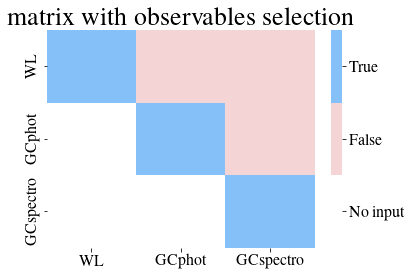

Loading sigma8 emulator...


2022-02-16 16:48:47.755073: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Sigma8 emulator loaded in memory.
Loading linear emulator...


/opt/anaconda3/envs/nlcloe39/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/nlcloe39/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Linear emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...


/opt/anaconda3/envs/nlcloe39/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/nlcloe39/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator PCA from version 0.22.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/nlcloe39/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to bre

Baryonic Emulator loaded in memory.
Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...
Linear emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.
[CAMB] Importing *global* CAMB.
[camb] Initialized!
[model] *WARNING* Theories {camb, camb.transfers} do not appear to be actually used for anything
Time for initialization of the likelihood:  6.947684049606323


In [8]:
from cobaya.model import get_model

from likelihood.auxiliary.likelihood_yaml_handler import set_halofit_version
set_halofit_version(info, info['likelihood']['Euclid']['NL_flag'])
# The `get_model` function of Cobaya imported in the line above needs a yaml or dictionary as an argument
# 
# We measure the time to give us an estimation of how much time it takes to make the initialization of the
# likelihood
t1 = time.time()

# Second: create an instance of the `model` wrapper called model
model = get_model(info)
print('Time for initialization of the likelihood: ', time.time()-t1)
# We need to sample the log posterior to create model.provider.params
logposterior = model.logposterior({})

In [9]:
# Create an instance of the class EuclidLikelihood and initialize it (general case)
like = EuclidLikelihood()
like.initialize()
like.passing_requirements(model, info, **model.provider.params)


/Users/pedro/Documents/IST_NL_git/like_NL/likelihood-implementation/likelihood/auxiliary/observables_dealer.py:68: UserWarning: Attention: CLOE only computes cross-correlations for the photometric survey!
  warnings.warn(
/Users/pedro/Documents/IST_NL_git/like_NL/likelihood-implementation/likelihood/auxiliary/observables_dealer.py:71: UserWarning: Entries ['WL']['GCphot'] and ['GCphot']['GCspec'] are changed to False.
  warnings.warn(


Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...
Linear emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.
Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...
Linear emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.
[CAMB] Importing *global* CAMB.
[camb] Initialized!
[model] *WARNING* Theories {camb, camb.transfers} do not appear to be actually used for anything
Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...
Linear emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loadin

[model] *WARNING* Ignored blocks/options: ['sampler', 'output', 'force']
[CAMB] Importing *global* CAMB.
[camb] Initialized!


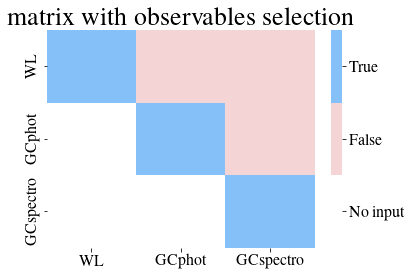

Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...
Linear emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.
Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...
Linear emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.
[CAMB] Importing *global* CAMB.
[camb] Initialized!
[model] *WARNING* Theories {camb.transfers, camb} do not appear to be actually used for anything


In [10]:
# New model with halofit
info['likelihood']['Euclid']['NL_flag']=1
set_halofit_version(info, info['likelihood']['Euclid']['NL_flag'])
model_1 = get_model(info)
logposterior = model_1.logposterior({})

In [11]:
# New instances of the class EuclidLikelihood with halofit

like_1 = EuclidLikelihood()
like_1.initialize()
like_1.passing_requirements(model_1, info, **model_1.provider.params)

Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...
Linear emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.
Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...
Linear emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear emulator...
Nonlinear emulator loaded in memory.
Loading Baryonic Emulator...
Baryonic Emulator loaded in memory.
[CAMB] Importing *global* CAMB.
[camb] Initialized!
[model] *WARNING* Theories {camb, camb.transfers} do not appear to be actually used for anything
Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading linear emulator...
Linear emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loadin

### Copy the cosmo dictionary and produce new ones for emulators

In [12]:
# This is just the scale at which to get the growth factor, it is used as an input for update_cosmo_dic
k_growth = 0.05

# The case NL_flag=1 is special, because it needs the different initializations of like and model
like_1.cosmo.cosmo_dic['NL_flag'] = 1
like_1.cosmo.update_cosmo_dic(like_1.cosmo.cosmo_dic['z_win'], k_growth)
cosmo_dic_1 = copy.copy(like_1.cosmo.cosmo_dic)


# These can all be done this way because they all use hmcode (when needed)
like.cosmo.cosmo_dic['NL_flag'] = 0
like.cosmo.update_cosmo_dic(like.cosmo.cosmo_dic['z_win'], k_growth)
cosmo_dic_0 = copy.copy(like.cosmo.cosmo_dic)

like.cosmo.cosmo_dic['NL_flag'] = 2
like.cosmo.update_cosmo_dic(like.cosmo.cosmo_dic['z_win'], k_growth)
cosmo_dic_2 = copy.copy(like.cosmo.cosmo_dic)

like.cosmo.cosmo_dic['NL_flag'] = 3
like.cosmo.update_cosmo_dic(like.cosmo.cosmo_dic['z_win'], k_growth)
cosmo_dic_3 = copy.copy(like.cosmo.cosmo_dic)

like.cosmo.cosmo_dic['NL_flag'] = 4
like.cosmo.update_cosmo_dic(like.cosmo.cosmo_dic['z_win'], k_growth)
cosmo_dic_4 = copy.copy(like.cosmo.cosmo_dic)

In [13]:
#like.cosmo.cosmo_dic['NL_flag'] = 3
#%time like.cosmo.update_cosmo_dic(like.cosmo.cosmo_dic['z_win'], k_growth)
#like_1.cosmo.cosmo_dic['NL_flag'] = 1
#%time like_1.cosmo.update_cosmo_dic(like_1.cosmo.cosmo_dic['z_win'], k_growth)
# Wall time: 226 ms for NL=2
# Wall time: 319 ms for NL=3
# Wall time: 554 ms for NL=4

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
## Choose k-array for plots
ks=np.logspace(-3, 1, 200)

In [16]:
## Obtain set of defined redshift range

like.cosmo.cosmo_dic['z_win']

array([0.        , 0.04040404, 0.08080808, 0.12121212, 0.16161616,
       0.2020202 , 0.24242424, 0.28282828, 0.32323232, 0.36363636,
       0.4040404 , 0.44444444, 0.48484848, 0.52525253, 0.56565657,
       0.60606061, 0.64646465, 0.68686869, 0.72727273, 0.76767677,
       0.80808081, 0.84848485, 0.88888889, 0.92929293, 0.96969697,
       1.01010101, 1.05050505, 1.09090909, 1.13131313, 1.17171717,
       1.21212121, 1.25252525, 1.29292929, 1.33333333, 1.37373737,
       1.41414141, 1.45454545, 1.49494949, 1.53535354, 1.57575758,
       1.61616162, 1.65656566, 1.6969697 , 1.73737374, 1.77777778,
       1.81818182, 1.85858586, 1.8989899 , 1.93939394, 1.97979798,
       2.02020202, 2.06060606, 2.1010101 , 2.14141414, 2.18181818,
       2.22222222, 2.26262626, 2.3030303 , 2.34343434, 2.38383838,
       2.42424242, 2.46464646, 2.50505051, 2.54545455, 2.58585859,
       2.62626263, 2.66666667, 2.70707071, 2.74747475, 2.78787879,
       2.82828283, 2.86868687, 2.90909091, 2.94949495, 2.98989

In [17]:
## Choose a set of z's to plot

z_chosen = [like.cosmo.cosmo_dic['z_win'][ii] for ii in [0,10,37,50]]
z_chosen

[0.0, 0.4040404040404041, 1.494949494949495, 2.0202020202020203]

### Plot the Pk_delta for all models

Pk_delta is just the linear camb Pk in all three

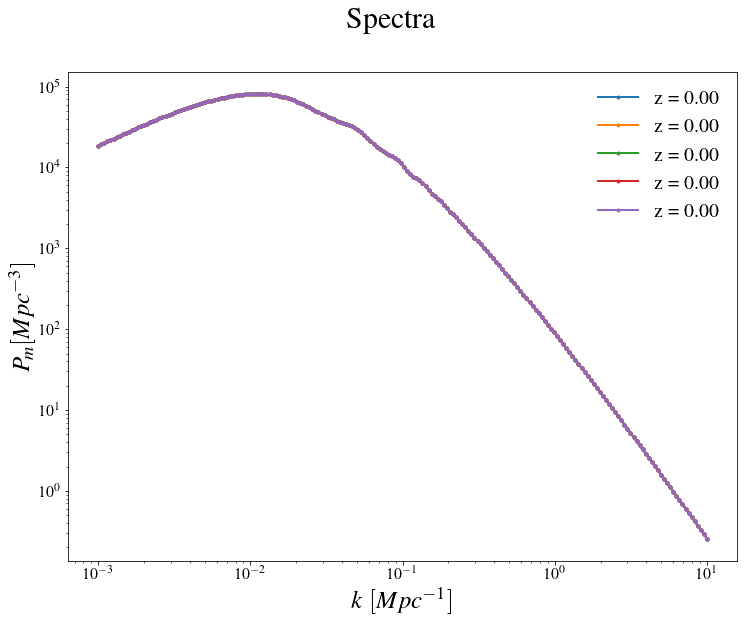

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(12,9))
fig.suptitle('Spectra')

ax=axs

z0=z_chosen[0]

ax.loglog(ks, cosmo_dic_0['Pk_delta'].P(z0, ks), '.-', 
           label=r"z = {:.2f}".format(z0))
ax.set_xlabel(r'$k$ $[{Mpc}^{-1}]$')
ax.set_ylabel(r'$P_m [{Mpc}^{-3}]$')
ax.legend(frameon=False)

ax.loglog(ks, cosmo_dic_1['Pk_delta'].P(z0, ks), '.-', 
           label=r"z = {:.2f}".format(z0))
ax.set_xlabel(r'$k$ $[{Mpc}^{-1}]$')
ax.set_ylabel(r'$P_m [{Mpc}^{-3}]$')
ax.legend(frameon=False)
#------
ax.loglog(ks, cosmo_dic_2['Pk_delta'].P(z0, ks), '.-', 
           label=r"z = {:.2f}".format(z0))
ax.set_xlabel(r'$k$ $[Mpc^{-1}]$')
ax.set_ylabel(r'$P_m [Mpc^{-3}]$')
ax.legend(frameon=False)
#
ax.loglog(ks, cosmo_dic_3['Pk_delta'].P(z0, ks), '.-', 
           label=r"z = {:.2f}".format(z0))
ax.set_xlabel(r'$k$ $[Mpc^{-1}]$')
ax.set_ylabel(r'$P_m [Mpc^{-3}]$')
ax.legend(frameon=False)
#
ax.loglog(ks, cosmo_dic_4['Pk_delta'].P(z0, ks), '.-', 
           label=r"z = {:.2f}".format(z0))
ax.set_xlabel(r'$k$ $[Mpc^{-1}]$')
ax.set_ylabel(r'$P_m [Mpc^{-3}]$')
ax.legend(frameon=False)

In [19]:
from matplotlib.pyplot import cm
from matplotlib.cm import get_cmap

In [20]:
## Define a color palette for the plots
name = "Dark2"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors

### Plot the Pgg_photo

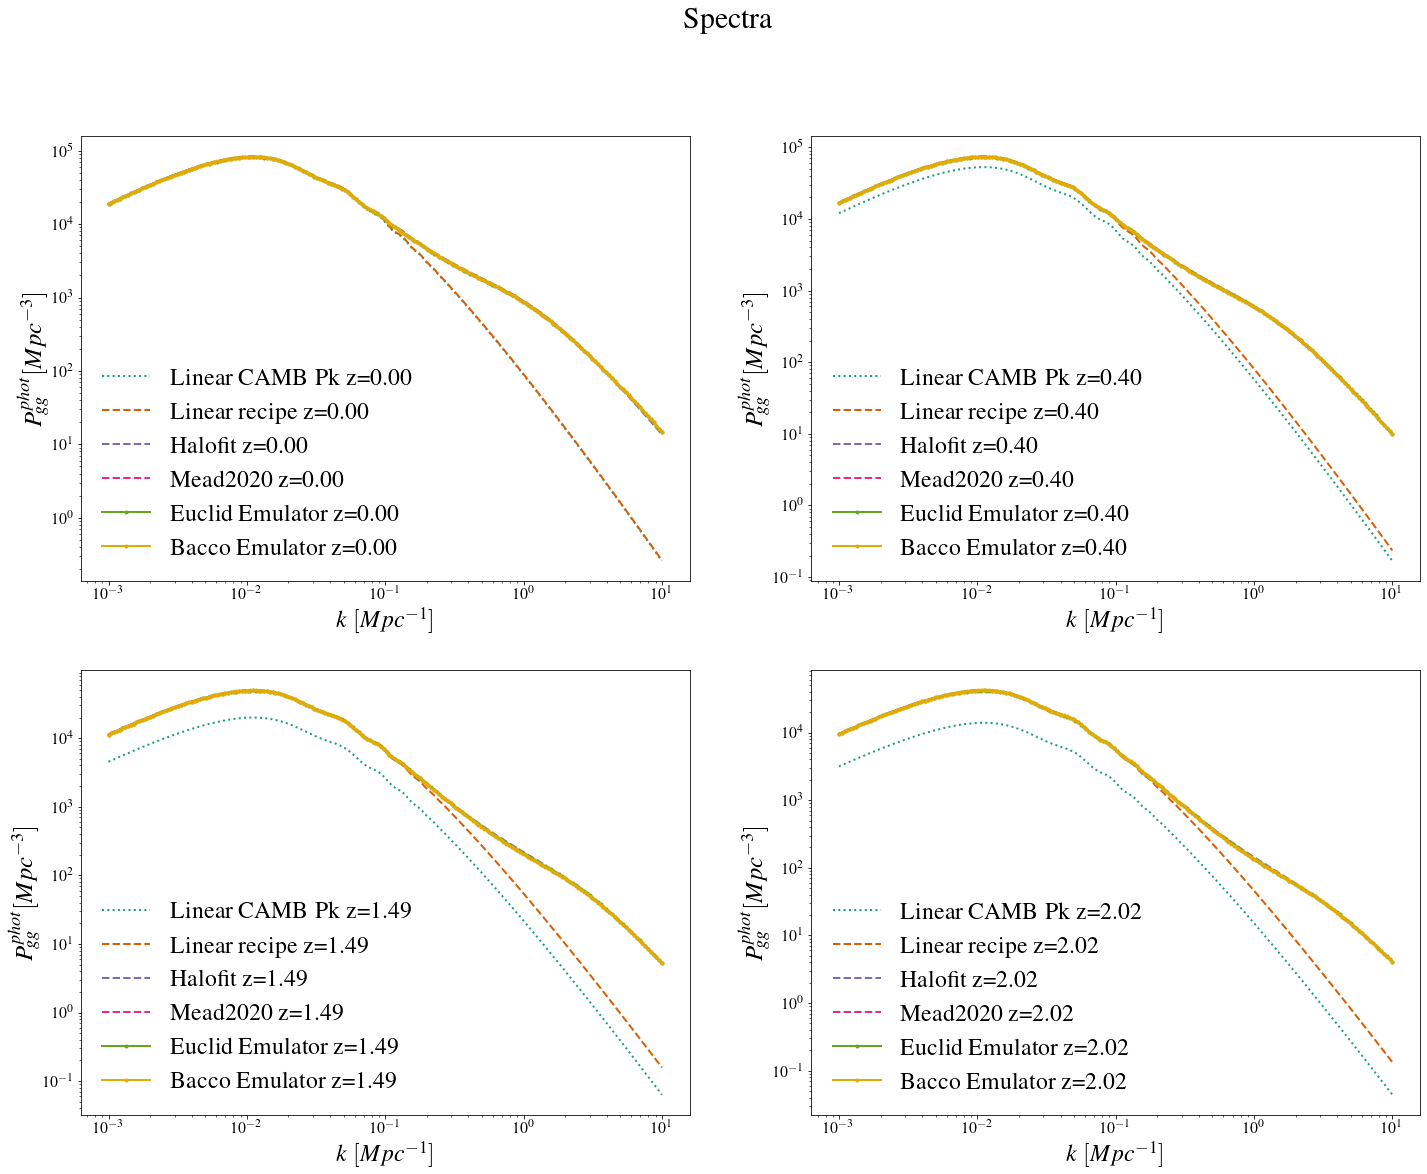

In [21]:
## Create four panels, one for each of the chosen redshifts above

fig, axs = plt.subplots(2, 2, figsize=(24,18))
fig.suptitle('Spectra')

ax=axs[0,0]

Pab = 'Pgg_phot'


for iz in range(4):
    if iz==0:
        ax=axs[0,0]
    if iz==1:
        ax=axs[0,1]
    if iz==2:
        ax=axs[1,0]
    if iz==3:
        ax=axs[1,1]
    z0=z_chosen[iz]

    ax.loglog(ks, cosmo_dic_1['Pk_delta'].P(z0, ks), ':', 
               label=r"Linear CAMB Pk z={:.2f}".format(z0), c=colors[0])
    
    
    ax.loglog(ks, cosmo_dic_0[Pab](z0, ks).flatten(), '--', 
               label=r"Linear recipe z={:.2f}".format(z0), c=colors[1])
    
    #------
    ax.loglog(ks, cosmo_dic_1[Pab](z0, ks).flatten(), '--', 
               label=r"Halofit z={:.2f}".format(z0), c=colors[2])
    
    #---
    
    
    ax.loglog(ks, cosmo_dic_2[Pab](z0, ks).flatten(), '--', 
               label=r"Mead2020 z={:.2f}".format(z0), c=colors[3])

    
    #
    ax.loglog(ks, cosmo_dic_3[Pab](z0, ks).flatten(), '.-', 
               label=r"Euclid Emulator z={:.2f}".format(z0), c=colors[4])
    
    ax.loglog(ks, cosmo_dic_4[Pab](z0, ks).flatten(), '.-', 
               label=r"Bacco Emulator z={:.2f}".format(z0), c=colors[5])
    
    ax.set_xlabel(r'$k$ $[{Mpc}^{-1}]$', fontsize=24)
    ax.set_ylabel(r'$P_{gg}^{phot} [{Mpc}^{-3}]$')
    ax.legend(frameon=False, fontsize=24)

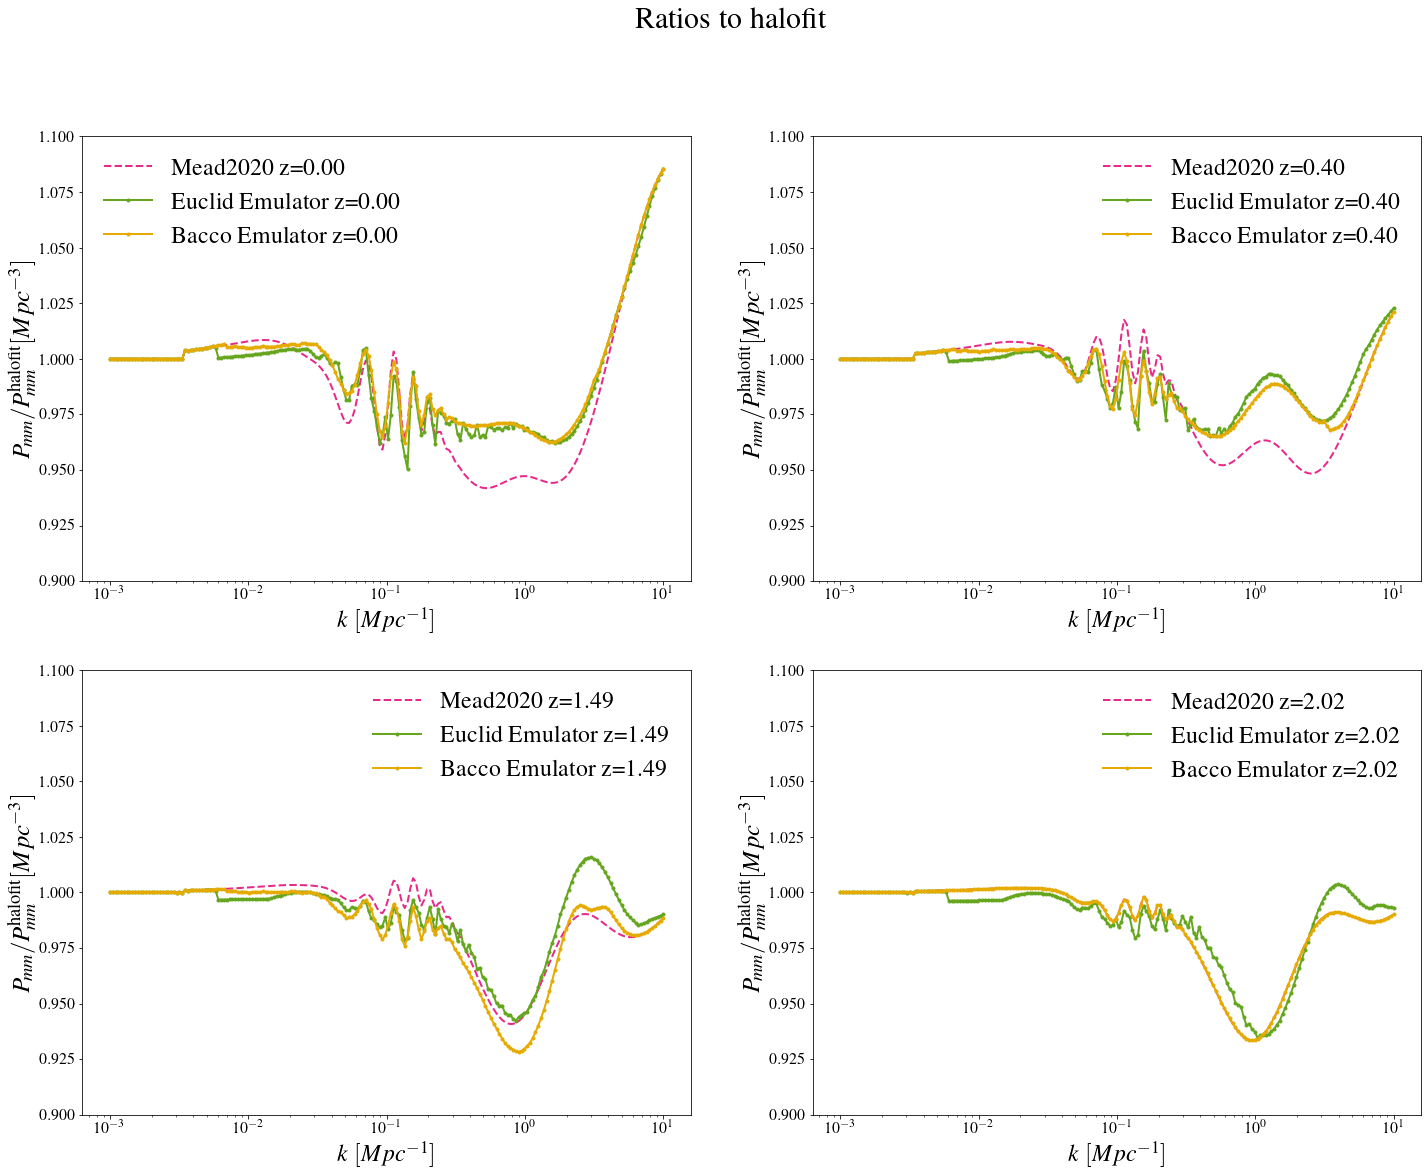

In [22]:
## Now the ratios

fig, axs = plt.subplots(2, 2, figsize=(24,18))
fig.suptitle('Ratios to halofit')

ax=axs[0,0]

Pab = 'Pmm_phot'


for iz in range(4):
    if iz==0:
        ax=axs[0,0]
    if iz==1:
        ax=axs[0,1]
    if iz==2:
        ax=axs[1,0]
    if iz==3:
        ax=axs[1,1]
    z0=z_chosen[iz]
    
    #---
    
    ax.semilogx(ks, cosmo_dic_2[Pab](z0, ks).flatten()/cosmo_dic_1[Pab](z0, ks).flatten(), '--', 
               label=r"Mead2020 z={:.2f}".format(z0), c=colors[3])
    
    #
    ax.semilogx(ks, cosmo_dic_3[Pab](z0, ks).flatten()/cosmo_dic_1[Pab](z0, ks).flatten(), '.-', 
               label=r"Euclid Emulator z={:.2f}".format(z0), c=colors[4])
    
    ax.semilogx(ks, cosmo_dic_4[Pab](z0, ks).flatten()/cosmo_dic_1[Pab](z0, ks).flatten(), '.-', 
               label=r"Bacco Emulator z={:.2f}".format(z0), c=colors[5])
    
    ax.set_xlabel(r'$k$ $[{Mpc}^{-1}]$', fontsize=24)
    ax.set_ylabel(r'$P_{mm}/P_{mm}^{\rm halofit} [{Mpc}^{-3}]$')
    
    ax.set_ylim([0.9,1.1])
    
    ax.legend(frameon=False, fontsize=24)

### Plotting the C_ells manually using the Photo class and data Reader

In [23]:
from likelihood.photometric_survey.photo import Photo
from likelihood.data_reader.reader import Reader

In [24]:
data = like.likefinal.data
read_data = Reader(data)
read_data.compute_nz()
read_data.read_phot()
# As we currently don't have a way to load fiducial r(z), d(z) and
# H(z)s, these are currently set to match the ones from the cosmo_dic.
# This will need to be fixed once this is decided.

In [25]:
phot_ins_0 = Photo( cosmo_dic_0, read_data.nz_dict_WL,
                      read_data.nz_dict_GC_Phot)
phot_ins_1 = Photo( cosmo_dic_1, read_data.nz_dict_WL,
                      read_data.nz_dict_GC_Phot)
phot_ins_2 = Photo( cosmo_dic_2, read_data.nz_dict_WL,
                      read_data.nz_dict_GC_Phot)
phot_ins_3 = Photo( cosmo_dic_3, read_data.nz_dict_WL,
                      read_data.nz_dict_GC_Phot)
phot_ins_4 = Photo( cosmo_dic_4, read_data.nz_dict_WL,
                      read_data.nz_dict_GC_Phot)

In [26]:
ells= np.logspace(np.log10(10), np.log10(5000), 100)

In [27]:
ClGC_0 = phot_ins_0.Cl_GC_phot
ClGC_1 = phot_ins_1.Cl_GC_phot
ClGC_2 = phot_ins_2.Cl_GC_phot
ClGC_3 = phot_ins_3.Cl_GC_phot
ClGC_4 = phot_ins_4.Cl_GC_phot

In [28]:
ClWL_0 = phot_ins_0.Cl_WL
ClWL_1 = phot_ins_1.Cl_WL
ClWL_2 = phot_ins_2.Cl_WL
ClWL_3 = phot_ins_3.Cl_WL
ClWL_4 = phot_ins_4.Cl_WL

In [29]:
ClGCxWL_0 = phot_ins_0.Cl_cross
ClGCxWL_1 = phot_ins_1.Cl_cross
ClGCxWL_2 = phot_ins_2.Cl_cross
ClGCxWL_3 = phot_ins_3.Cl_cross
ClGCxWL_4 = phot_ins_4.Cl_cross

### Plotting the WL C_ells

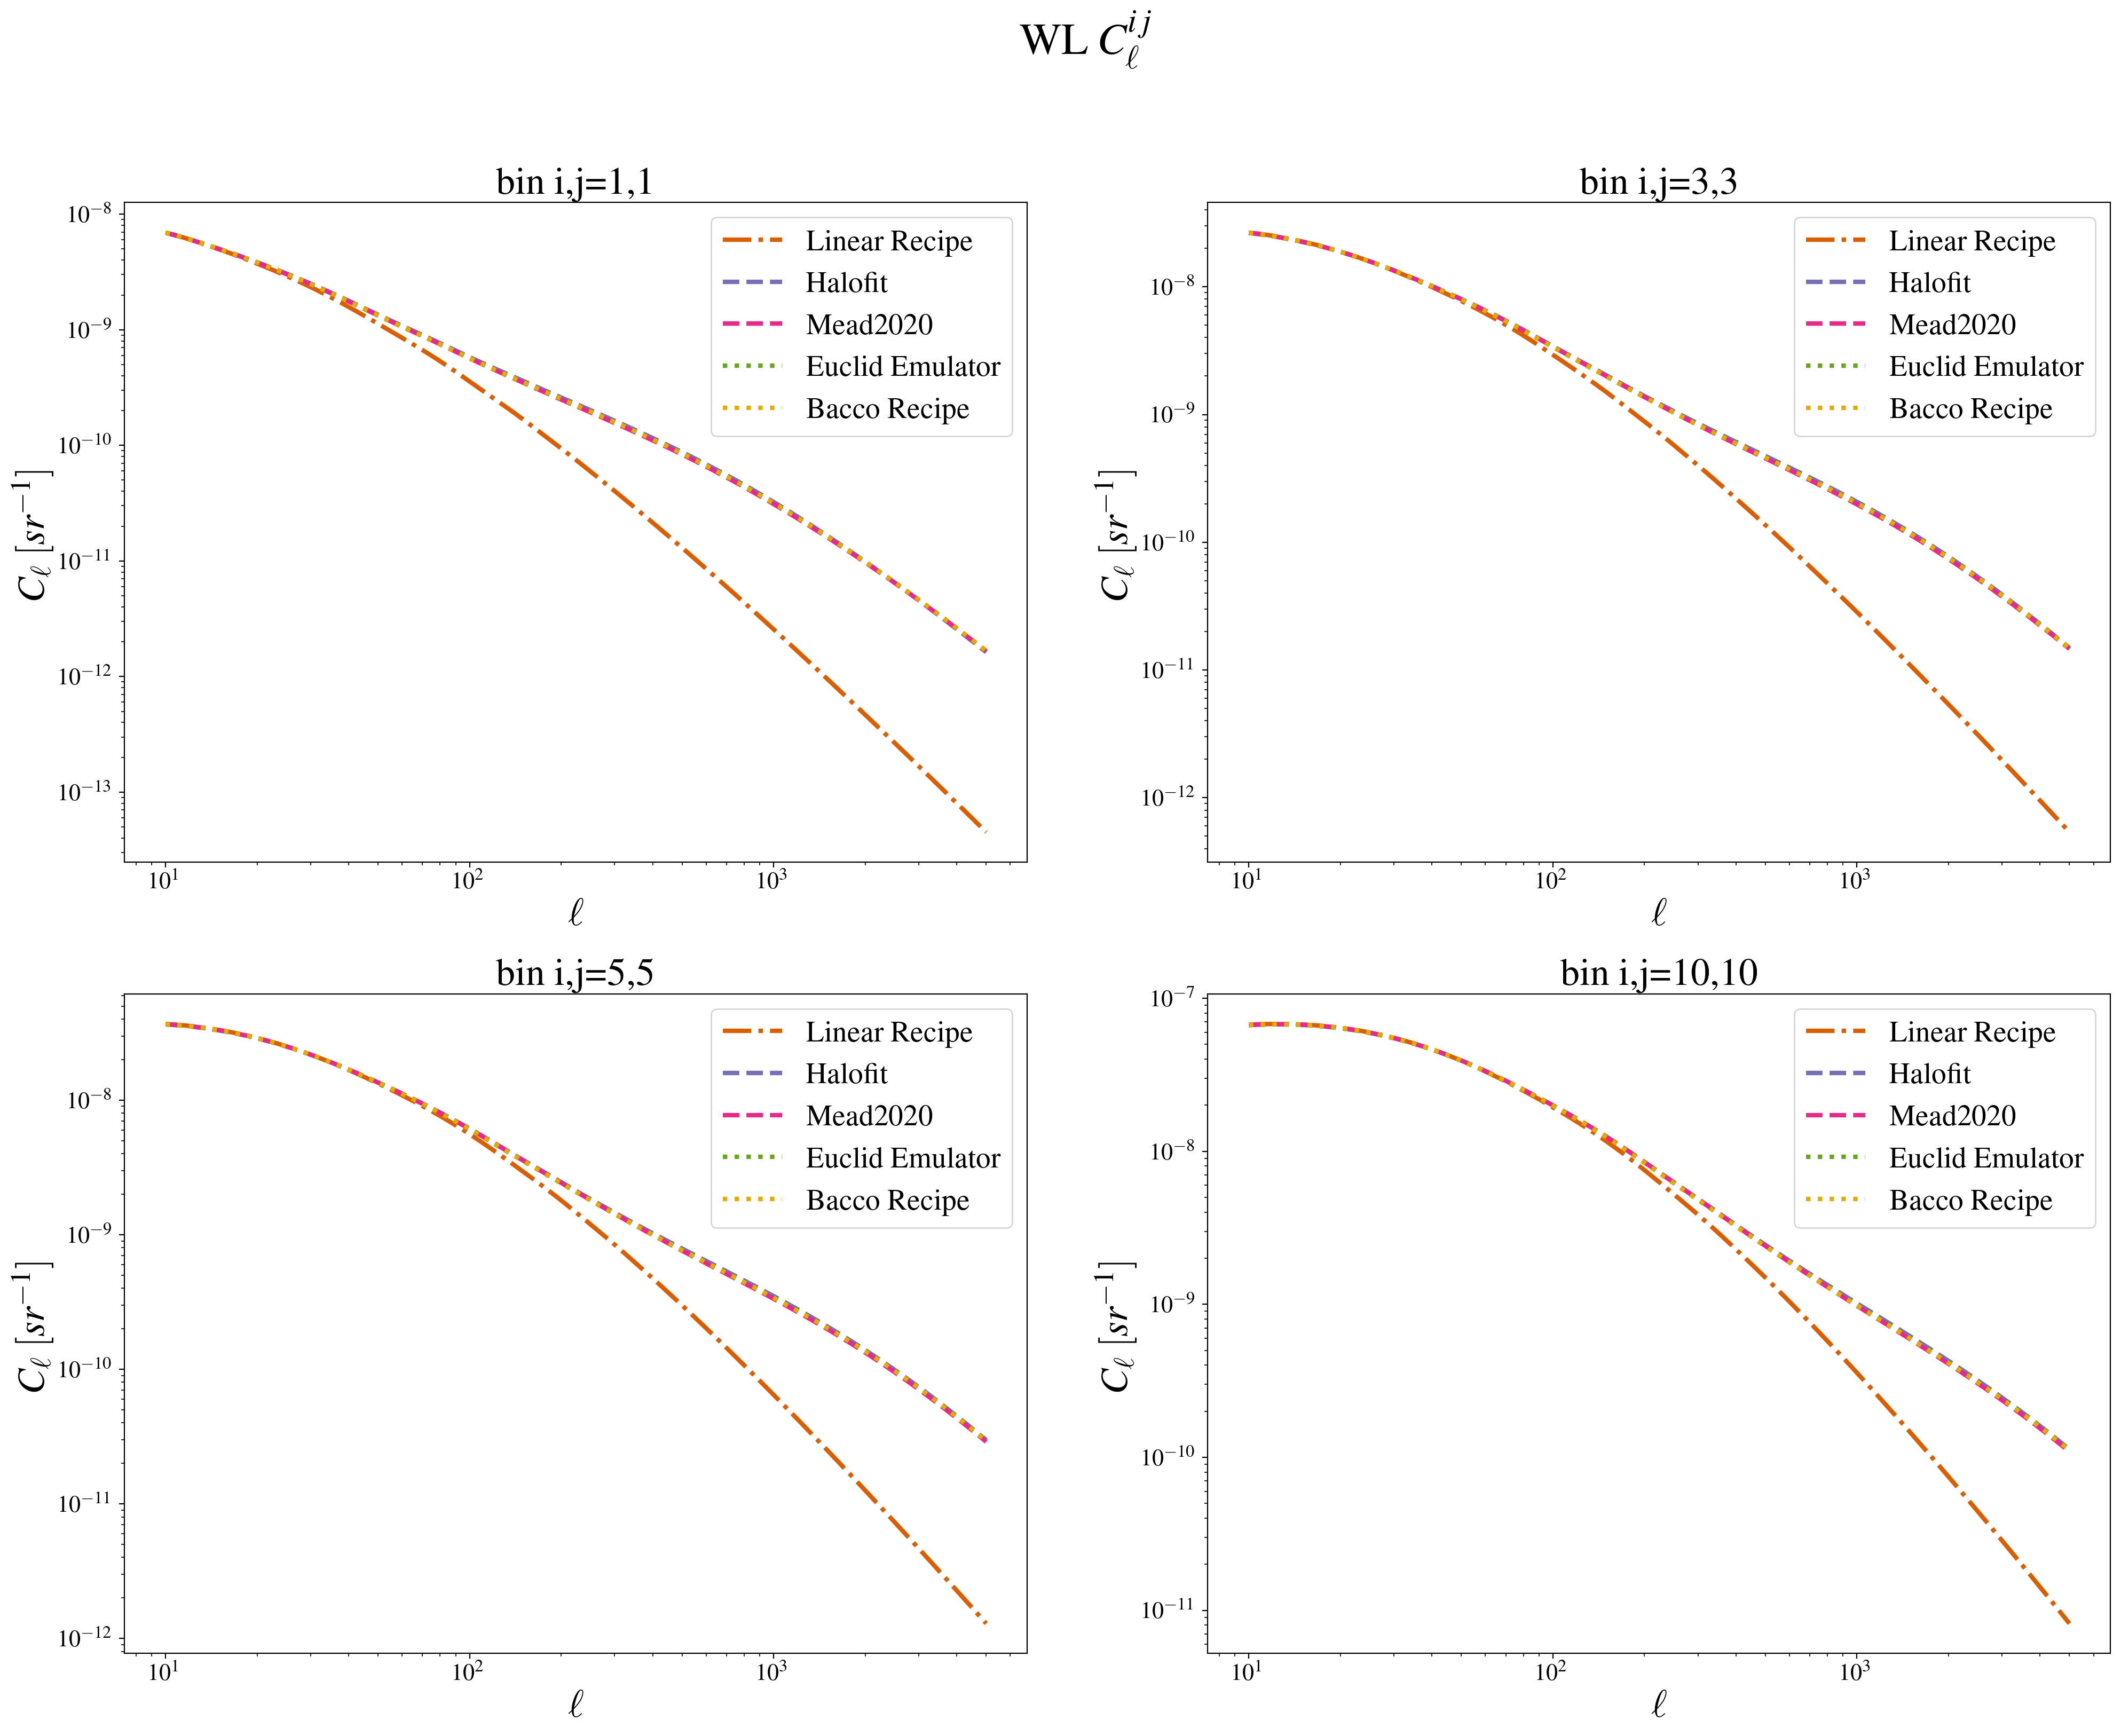

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(24,18), dpi=200)
fig.suptitle(r'WL $C^{ij}_{\ell}$')

iz_dict={1:[0,0], 3:[0,1], 5:[1,0], 10:[1,1]}

for iz in [1,3,5,10]:
    
    ax1 = axs[iz_dict[iz][0],iz_dict[iz][1]]
    
    pl_label_0 = 'Linear Recipe'
    ax1.loglog(ells, [ClWL_0(cur_ell, iz, iz) for cur_ell in ells], color=colors[1], ls='-.', label=pl_label_0, lw=3)
    
    pl_label_1 = 'Halofit'
    ax1.loglog(ells, [ClWL_1(cur_ell, iz, iz) for cur_ell in ells], color=colors[2], ls='--', label=pl_label_1, lw=3)
    
    pl_label_2 = 'Mead2020'
    ax1.loglog(ells, [ClWL_2(cur_ell, iz, iz) for cur_ell in ells], color=colors[3], ls='--', label=pl_label_2, lw=3)
    
    pl_label_3 = 'Euclid Emulator'
    ax1.loglog(ells, [ClWL_3(cur_ell, iz, iz) for cur_ell in ells], color=colors[4], ls=':', label=pl_label_3, lw=3)
    
    pl_label_4 = 'Bacco Recipe'
    ax1.loglog(ells, [ClWL_4(cur_ell, iz, iz) for cur_ell in ells], color=colors[5], ls=':', label=pl_label_4, lw=3)
    
    ax1.set_xlabel(r'$\ell$', fontsize=26)
    ax1.set_ylabel(r'$C_\ell$ $[sr^{-1}]$', fontsize=26)
    ax1.set_title('bin i,j={:d},{:d}'.format(iz,iz))
    ax1.legend();

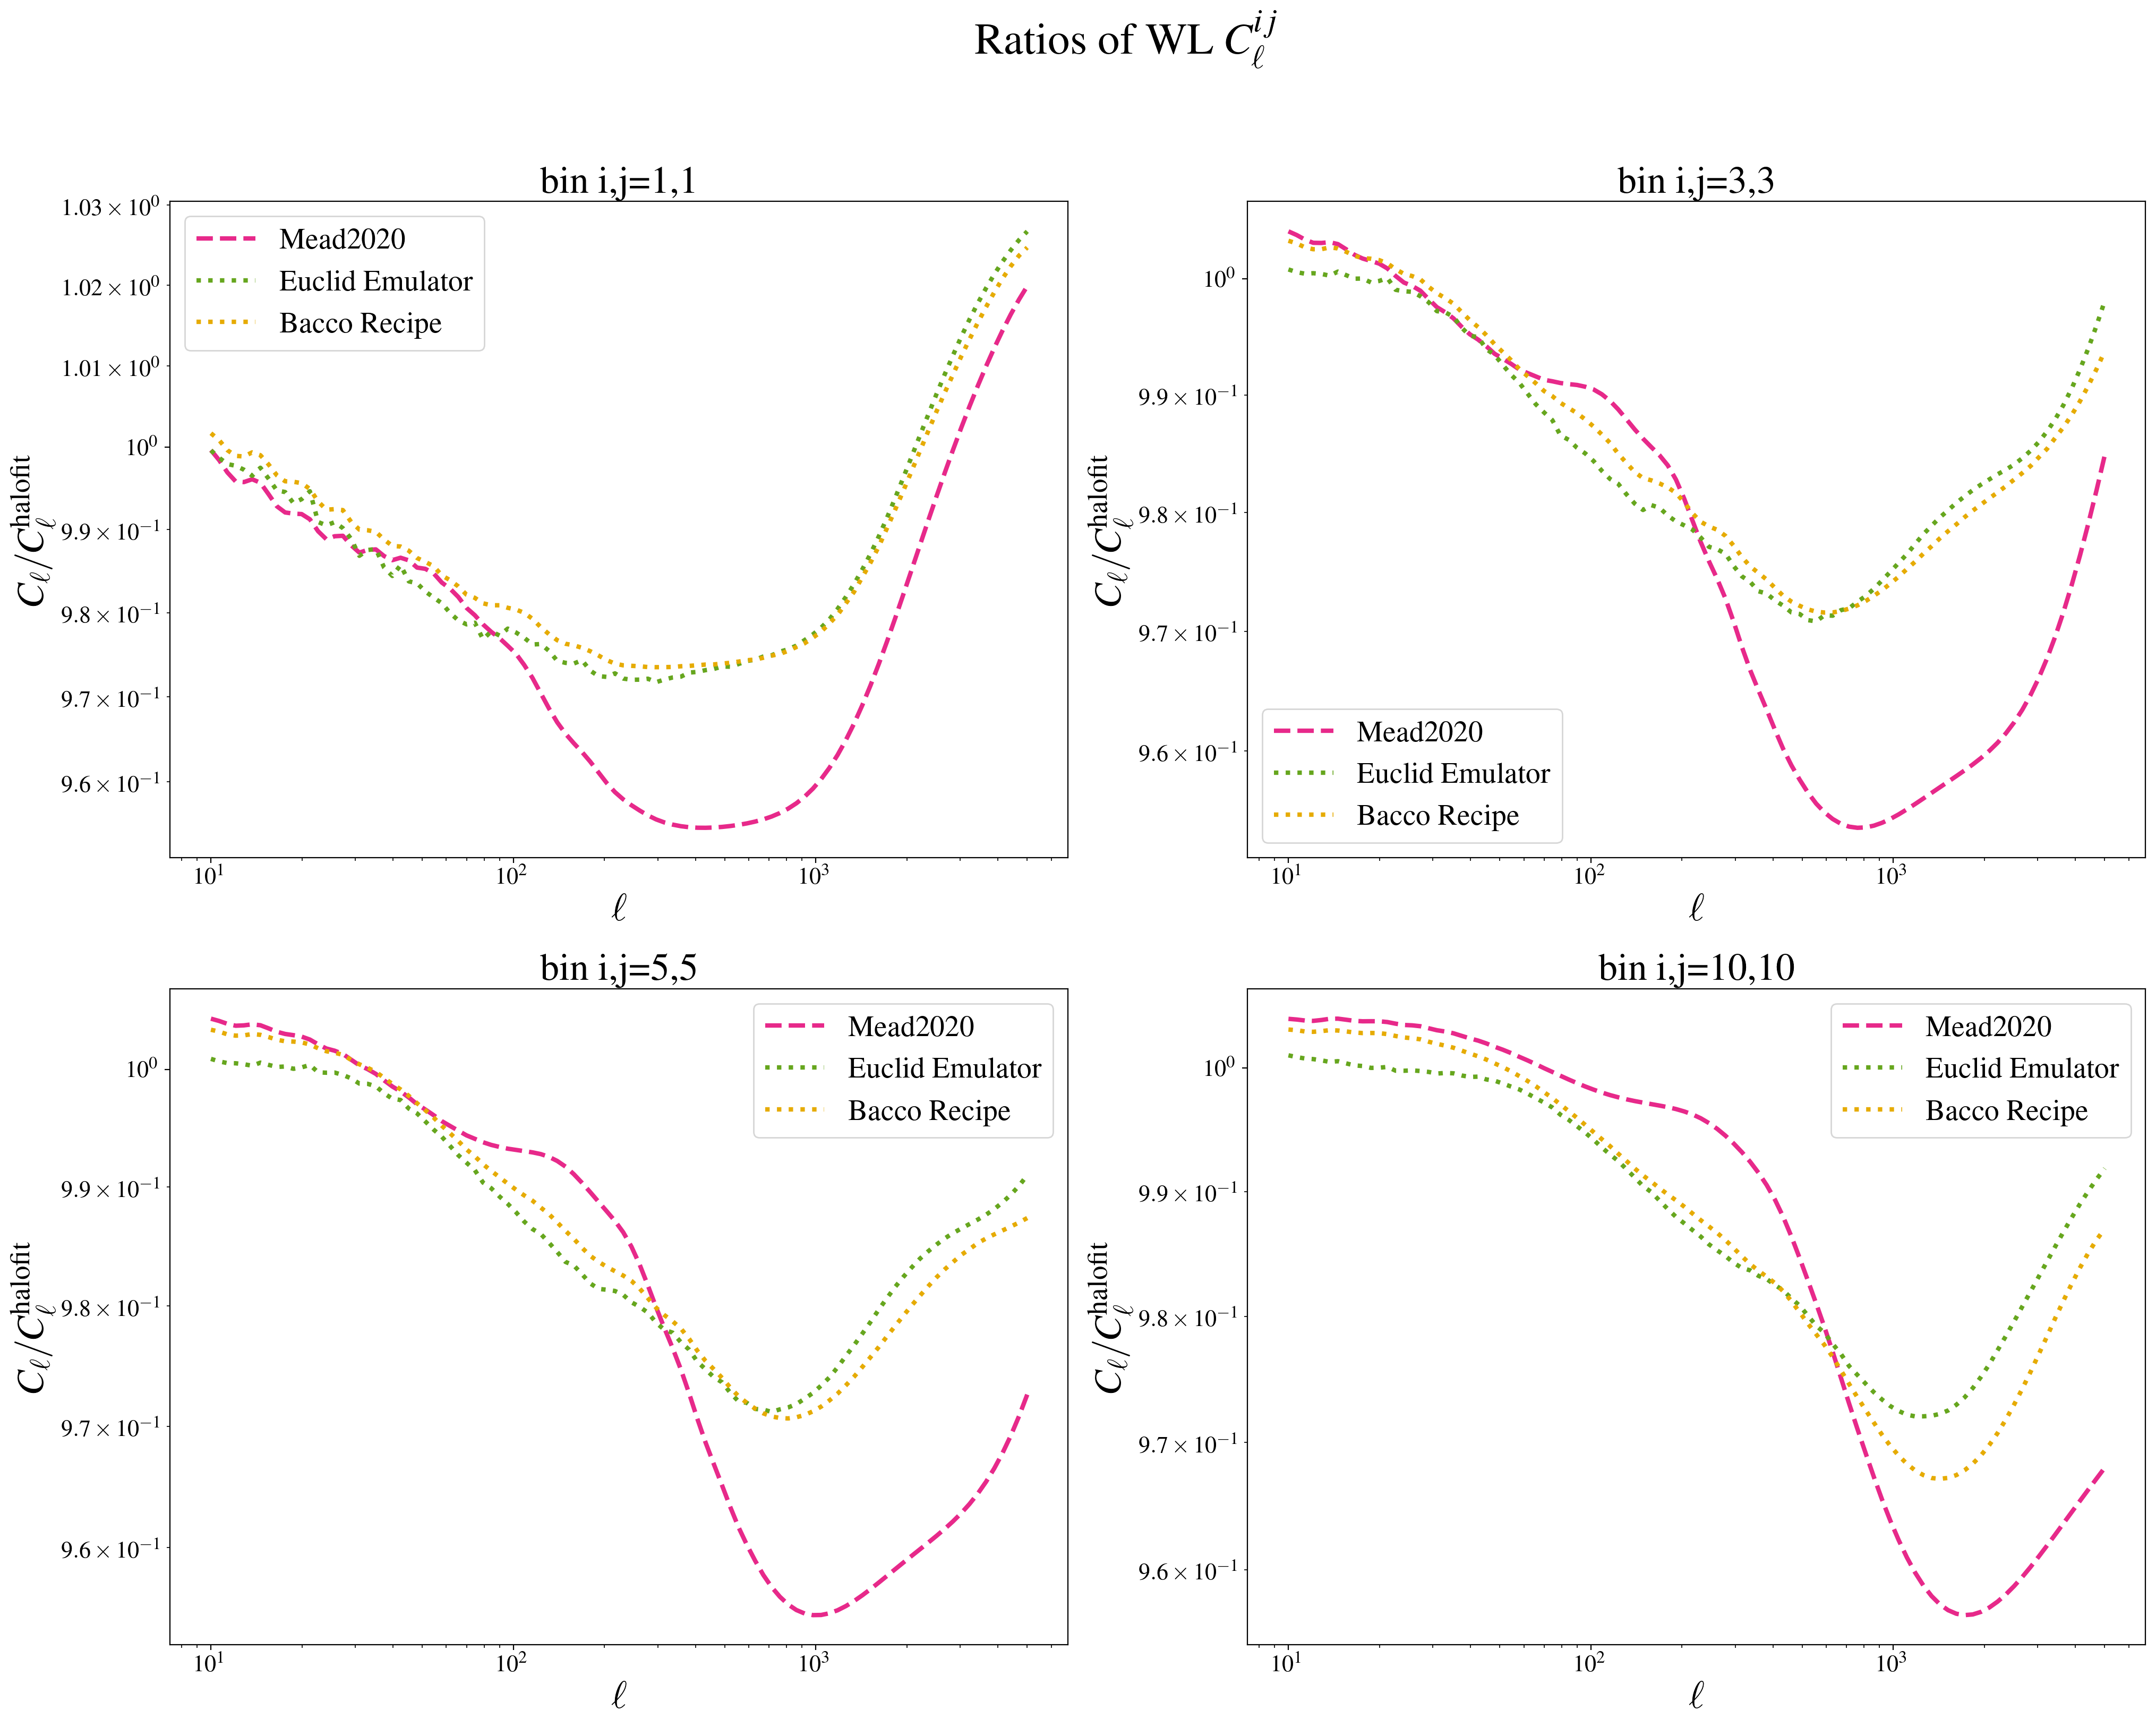

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(24,18), dpi=200)
fig.suptitle(r'Ratios of WL $C^{ij}_{\ell}$')

iz_dict={1:[0,0], 3:[0,1], 5:[1,0], 10:[1,1]}

for iz in [1,3,5,10]:
    
    ax1 = axs[iz_dict[iz][0],iz_dict[iz][1]]
      
    pl_label_2 = 'Mead2020'
    ax1.loglog(ells, [ClWL_2(cur_ell, iz, iz)/ClWL_1(cur_ell, iz, iz) for cur_ell in ells], color=colors[3], ls='--', label=pl_label_2, lw=3)
    
    pl_label_3 = 'Euclid Emulator'
    ax1.loglog(ells, [ClWL_3(cur_ell, iz, iz)/ClWL_1(cur_ell, iz, iz) for cur_ell in ells], color=colors[4], ls=':', label=pl_label_3, lw=3)
    
    pl_label_4 = 'Bacco Recipe'
    ax1.loglog(ells, [ClWL_4(cur_ell, iz, iz)/ClWL_1(cur_ell, iz, iz) for cur_ell in ells], color=colors[5], ls=':', label=pl_label_4, lw=3)
    
    ax1.set_xlabel(r'$\ell$', fontsize=26)
    ax1.set_ylabel(r'$C_\ell/C_\ell^{\rm halofit}$', fontsize=26)
    ax1.set_title('bin i,j={:d},{:d}'.format(iz,iz))
    ax1.legend();

### Plotting the GC_phot C_ells

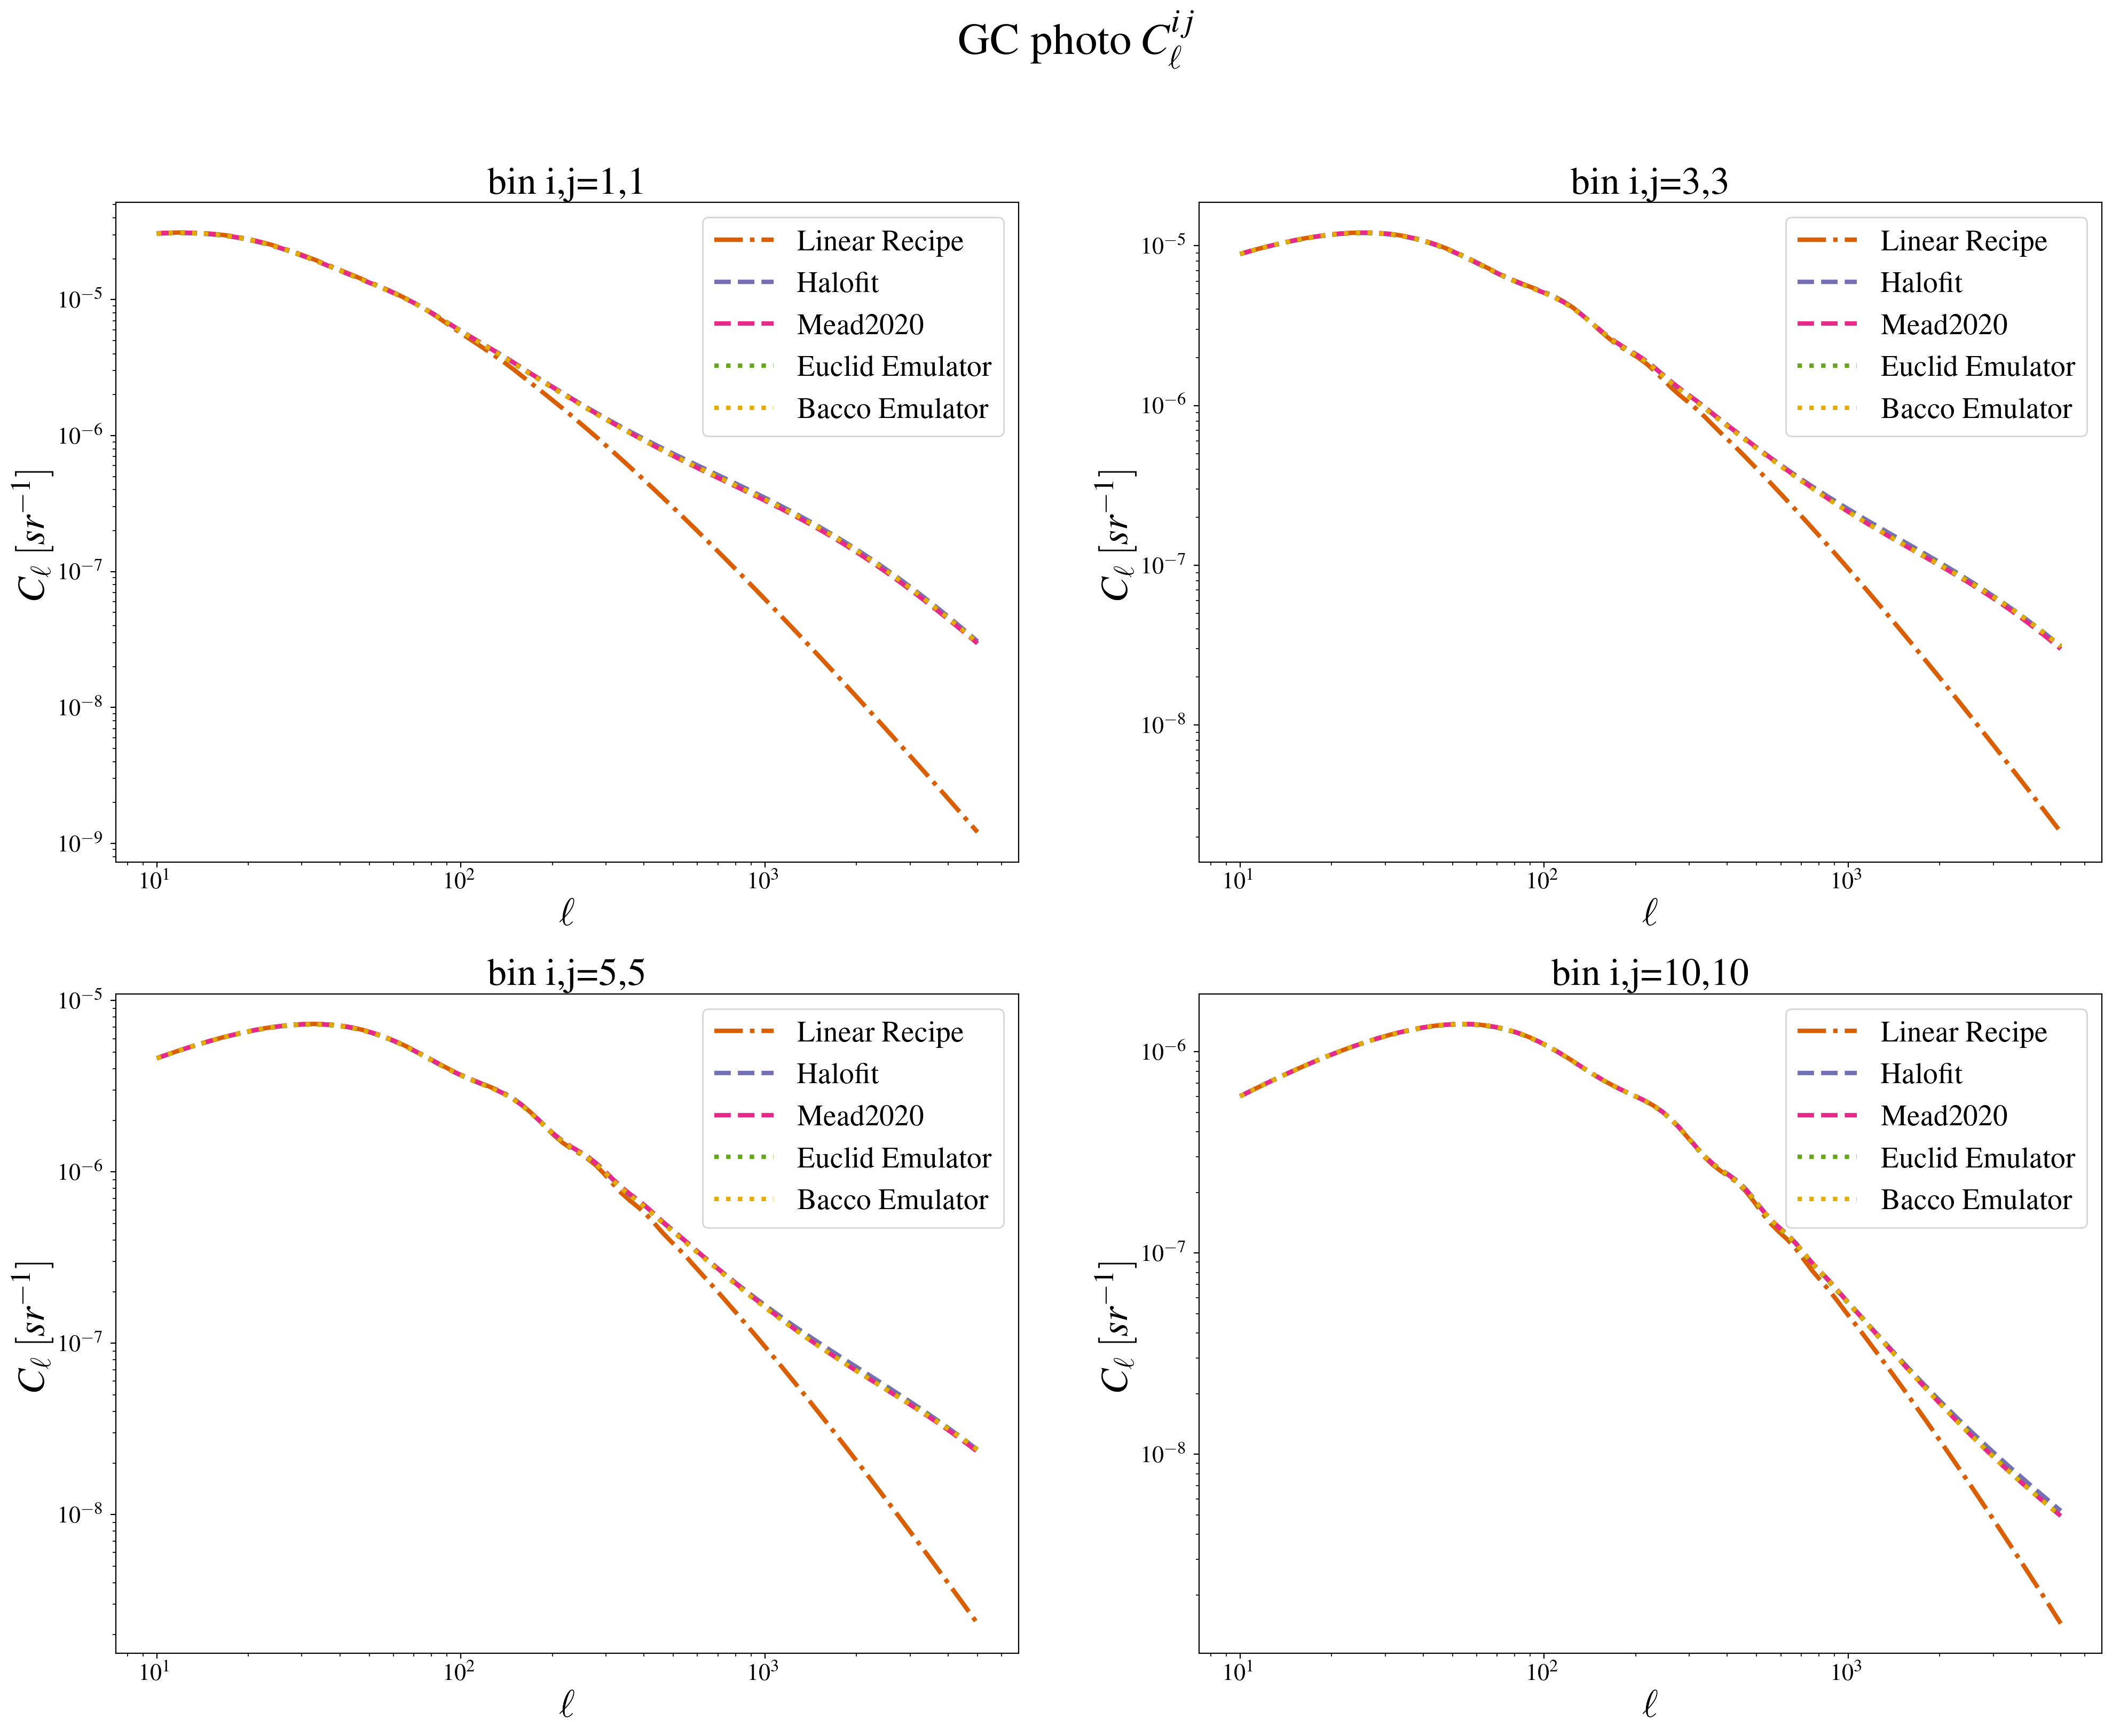

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(24,18), dpi=200)
fig.suptitle(r'GC photo $C^{ij}_{\ell}$')

iz_dict={1:[0,0], 3:[0,1], 5:[1,0], 10:[1,1]}

for iz in [1,3,5,10]:
    
    ax1 = axs[iz_dict[iz][0],iz_dict[iz][1]]
    
    pl_label_0 = 'Linear Recipe'
    ax1.loglog(ells, [ClGC_0(cur_ell, iz, iz) for cur_ell in ells], color=colors[1], ls='-.', label=pl_label_0, lw=3)
    
    pl_label_1 = 'Halofit'
    ax1.loglog(ells, [ClGC_1(cur_ell, iz, iz) for cur_ell in ells], color=colors[2], ls='--', label=pl_label_1, lw=3)
    
    pl_label_2 = 'Mead2020'
    ax1.loglog(ells, [ClGC_2(cur_ell, iz, iz) for cur_ell in ells], color=colors[3], ls='--', label=pl_label_2, lw=3)
    
    pl_label_3 = 'Euclid Emulator'
    ax1.loglog(ells, [ClGC_3(cur_ell, iz, iz) for cur_ell in ells], color=colors[4], ls=':', label=pl_label_3, lw=3)

    pl_label_4 = 'Bacco Emulator'
    ax1.loglog(ells, [ClGC_4(cur_ell, iz, iz) for cur_ell in ells], color=colors[5], ls=':', label=pl_label_4, lw=3)
    
    ax1.set_xlabel(r'$\ell$', fontsize=26)
    ax1.set_ylabel(r'$C_\ell$ $[sr^{-1}]$', fontsize=26)
    ax1.set_title('bin i,j={:d},{:d}'.format(iz,iz))
    ax1.legend();

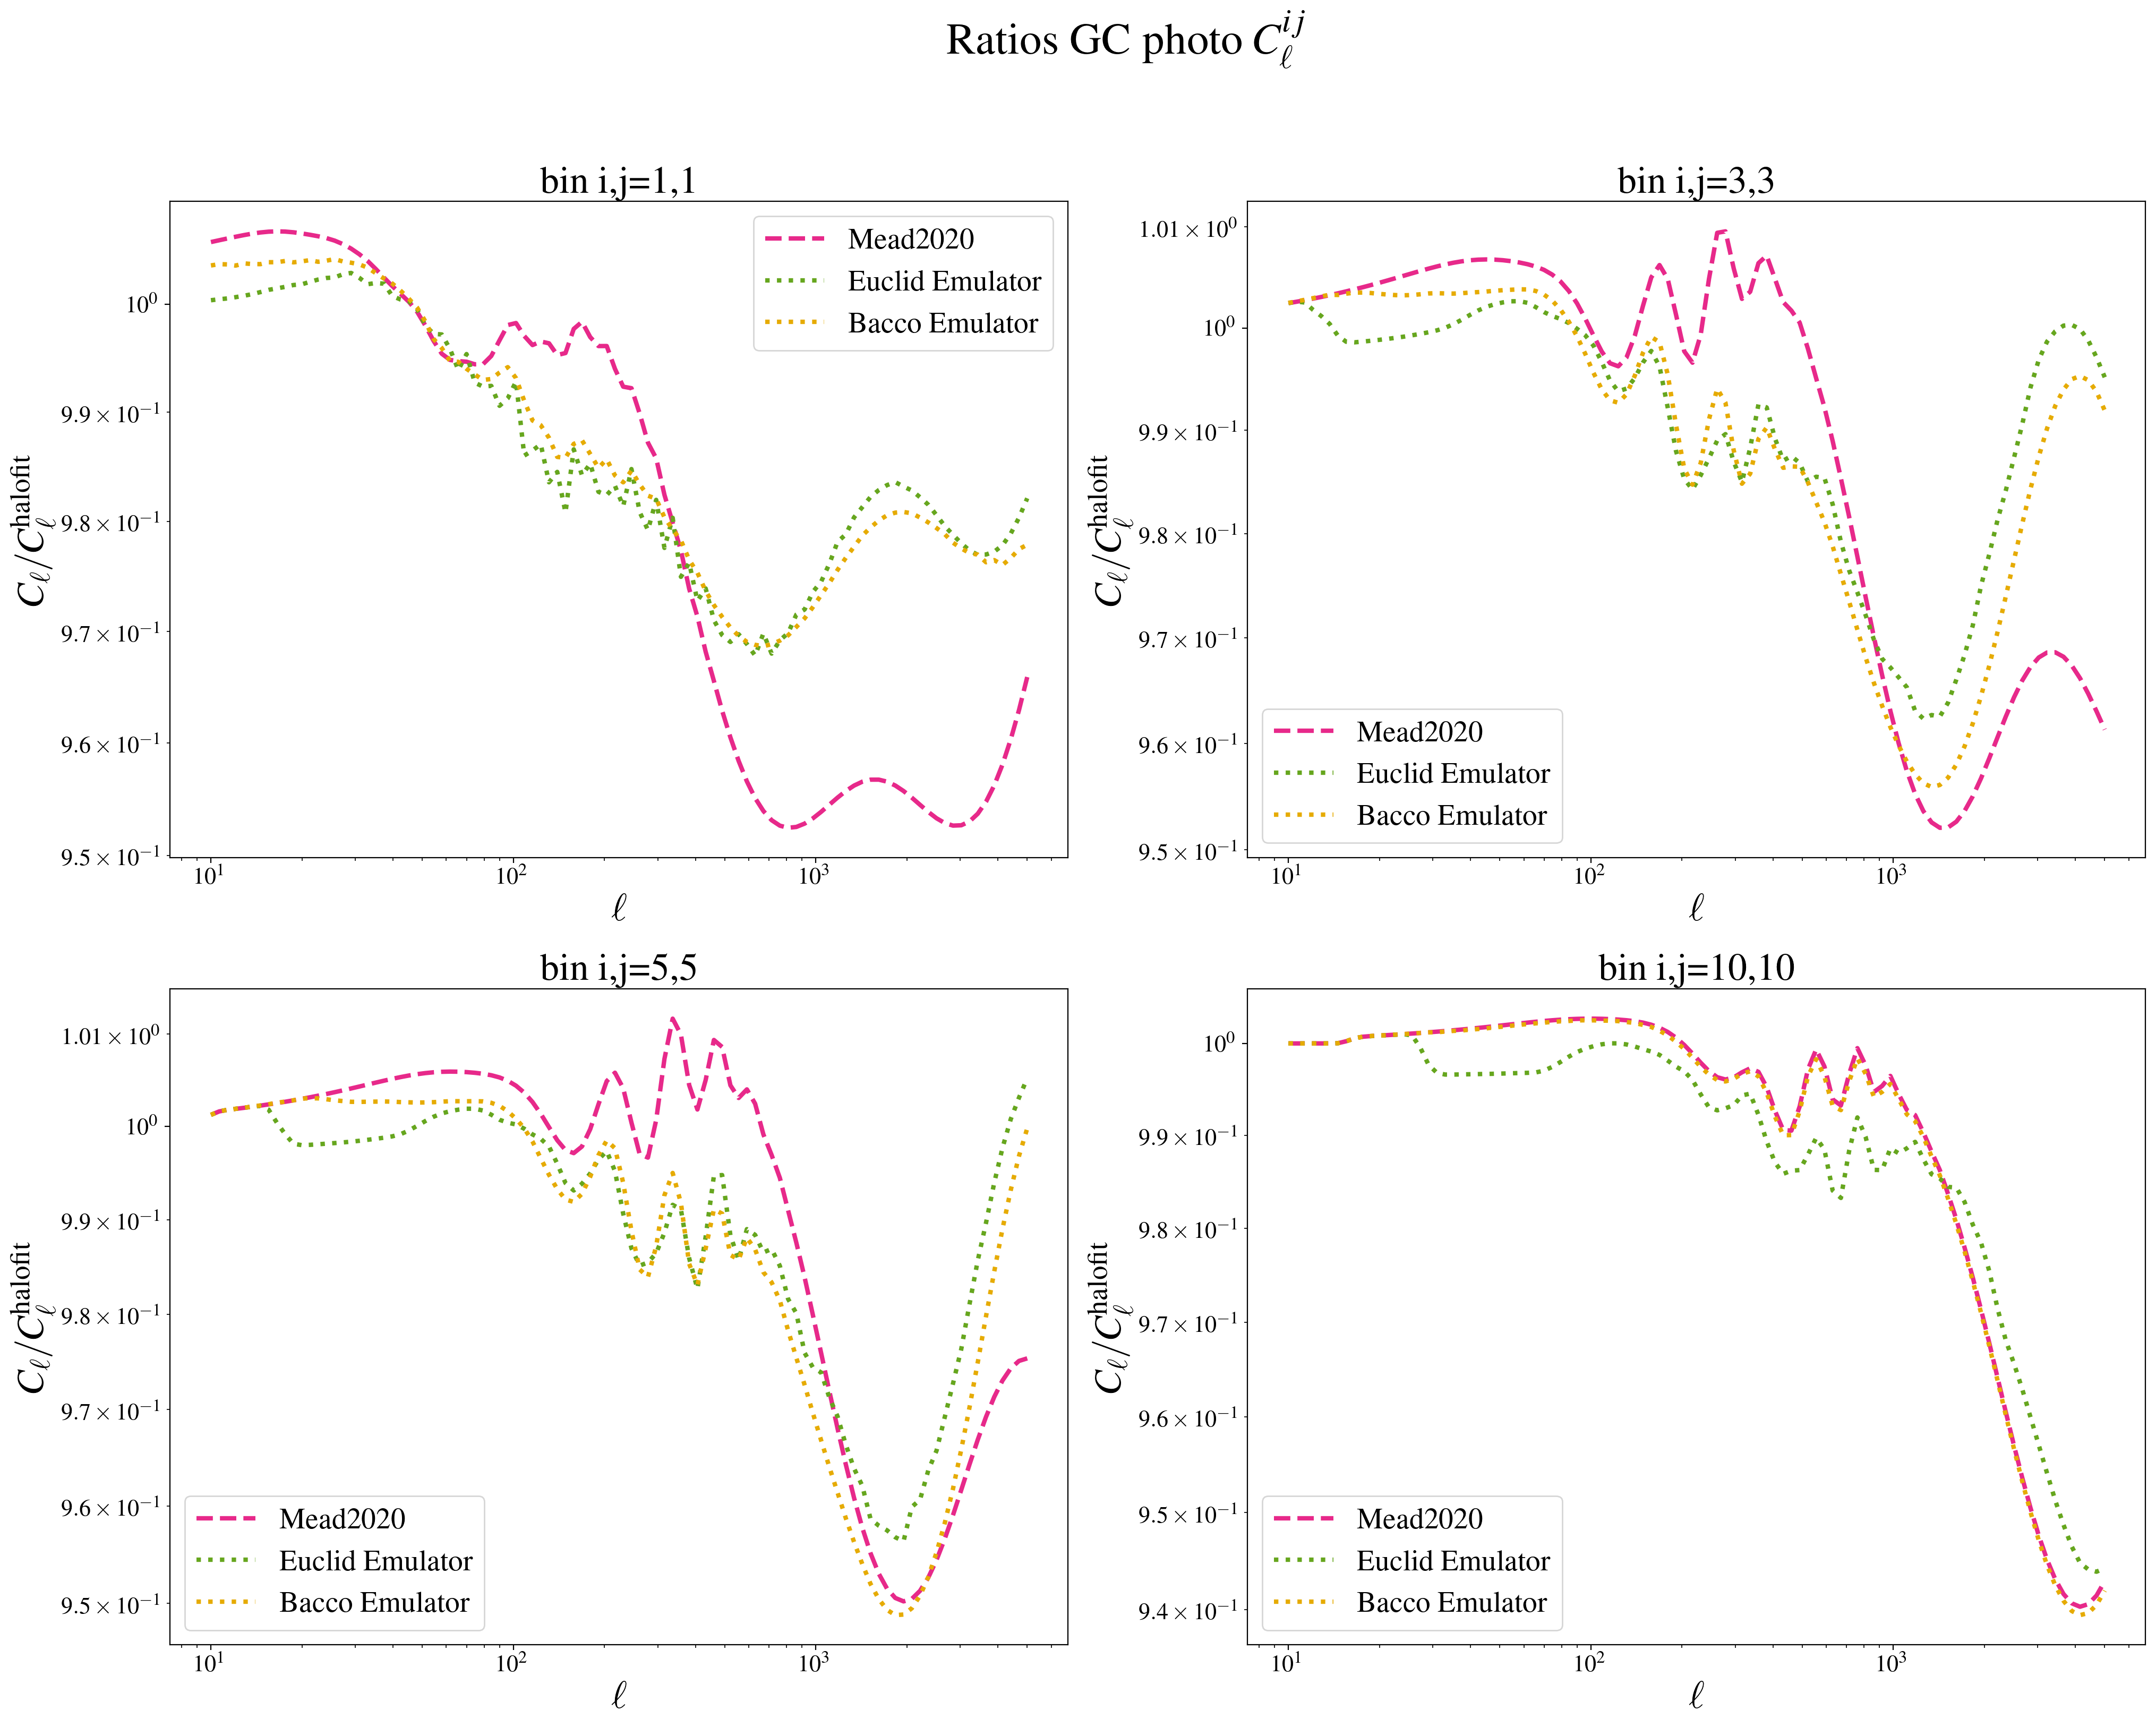

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(24,18), dpi=200)
fig.suptitle(r'Ratios GC photo $C^{ij}_{\ell}$')

iz_dict={1:[0,0], 3:[0,1], 5:[1,0], 10:[1,1]}

for iz in [1,3,5,10]:
    
    ax1 = axs[iz_dict[iz][0],iz_dict[iz][1]]
    
    pl_label_2 = 'Mead2020'
    ax1.loglog(ells, [ClGC_2(cur_ell, iz, iz)/ClGC_1(cur_ell, iz, iz) for cur_ell in ells], color=colors[3], ls='--', label=pl_label_2, lw=3)
    
    pl_label_3 = 'Euclid Emulator'
    ax1.loglog(ells, [ClGC_3(cur_ell, iz, iz)/ClGC_1(cur_ell, iz, iz) for cur_ell in ells], color=colors[4], ls=':', label=pl_label_3, lw=3)

    pl_label_4 = 'Bacco Emulator'
    ax1.loglog(ells, [ClGC_4(cur_ell, iz, iz)/ClGC_1(cur_ell, iz, iz) for cur_ell in ells], color=colors[5], ls=':', label=pl_label_4, lw=3)
    
    ax1.set_xlabel(r'$\ell$', fontsize=26)
    ax1.set_ylabel(r'$C_\ell/C_\ell^{\rm halofit}$', fontsize=26)
    ax1.set_title('bin i,j={:d},{:d}'.format(iz,iz))
    ax1.legend();

### Plotting the WL x GC photo Cl's

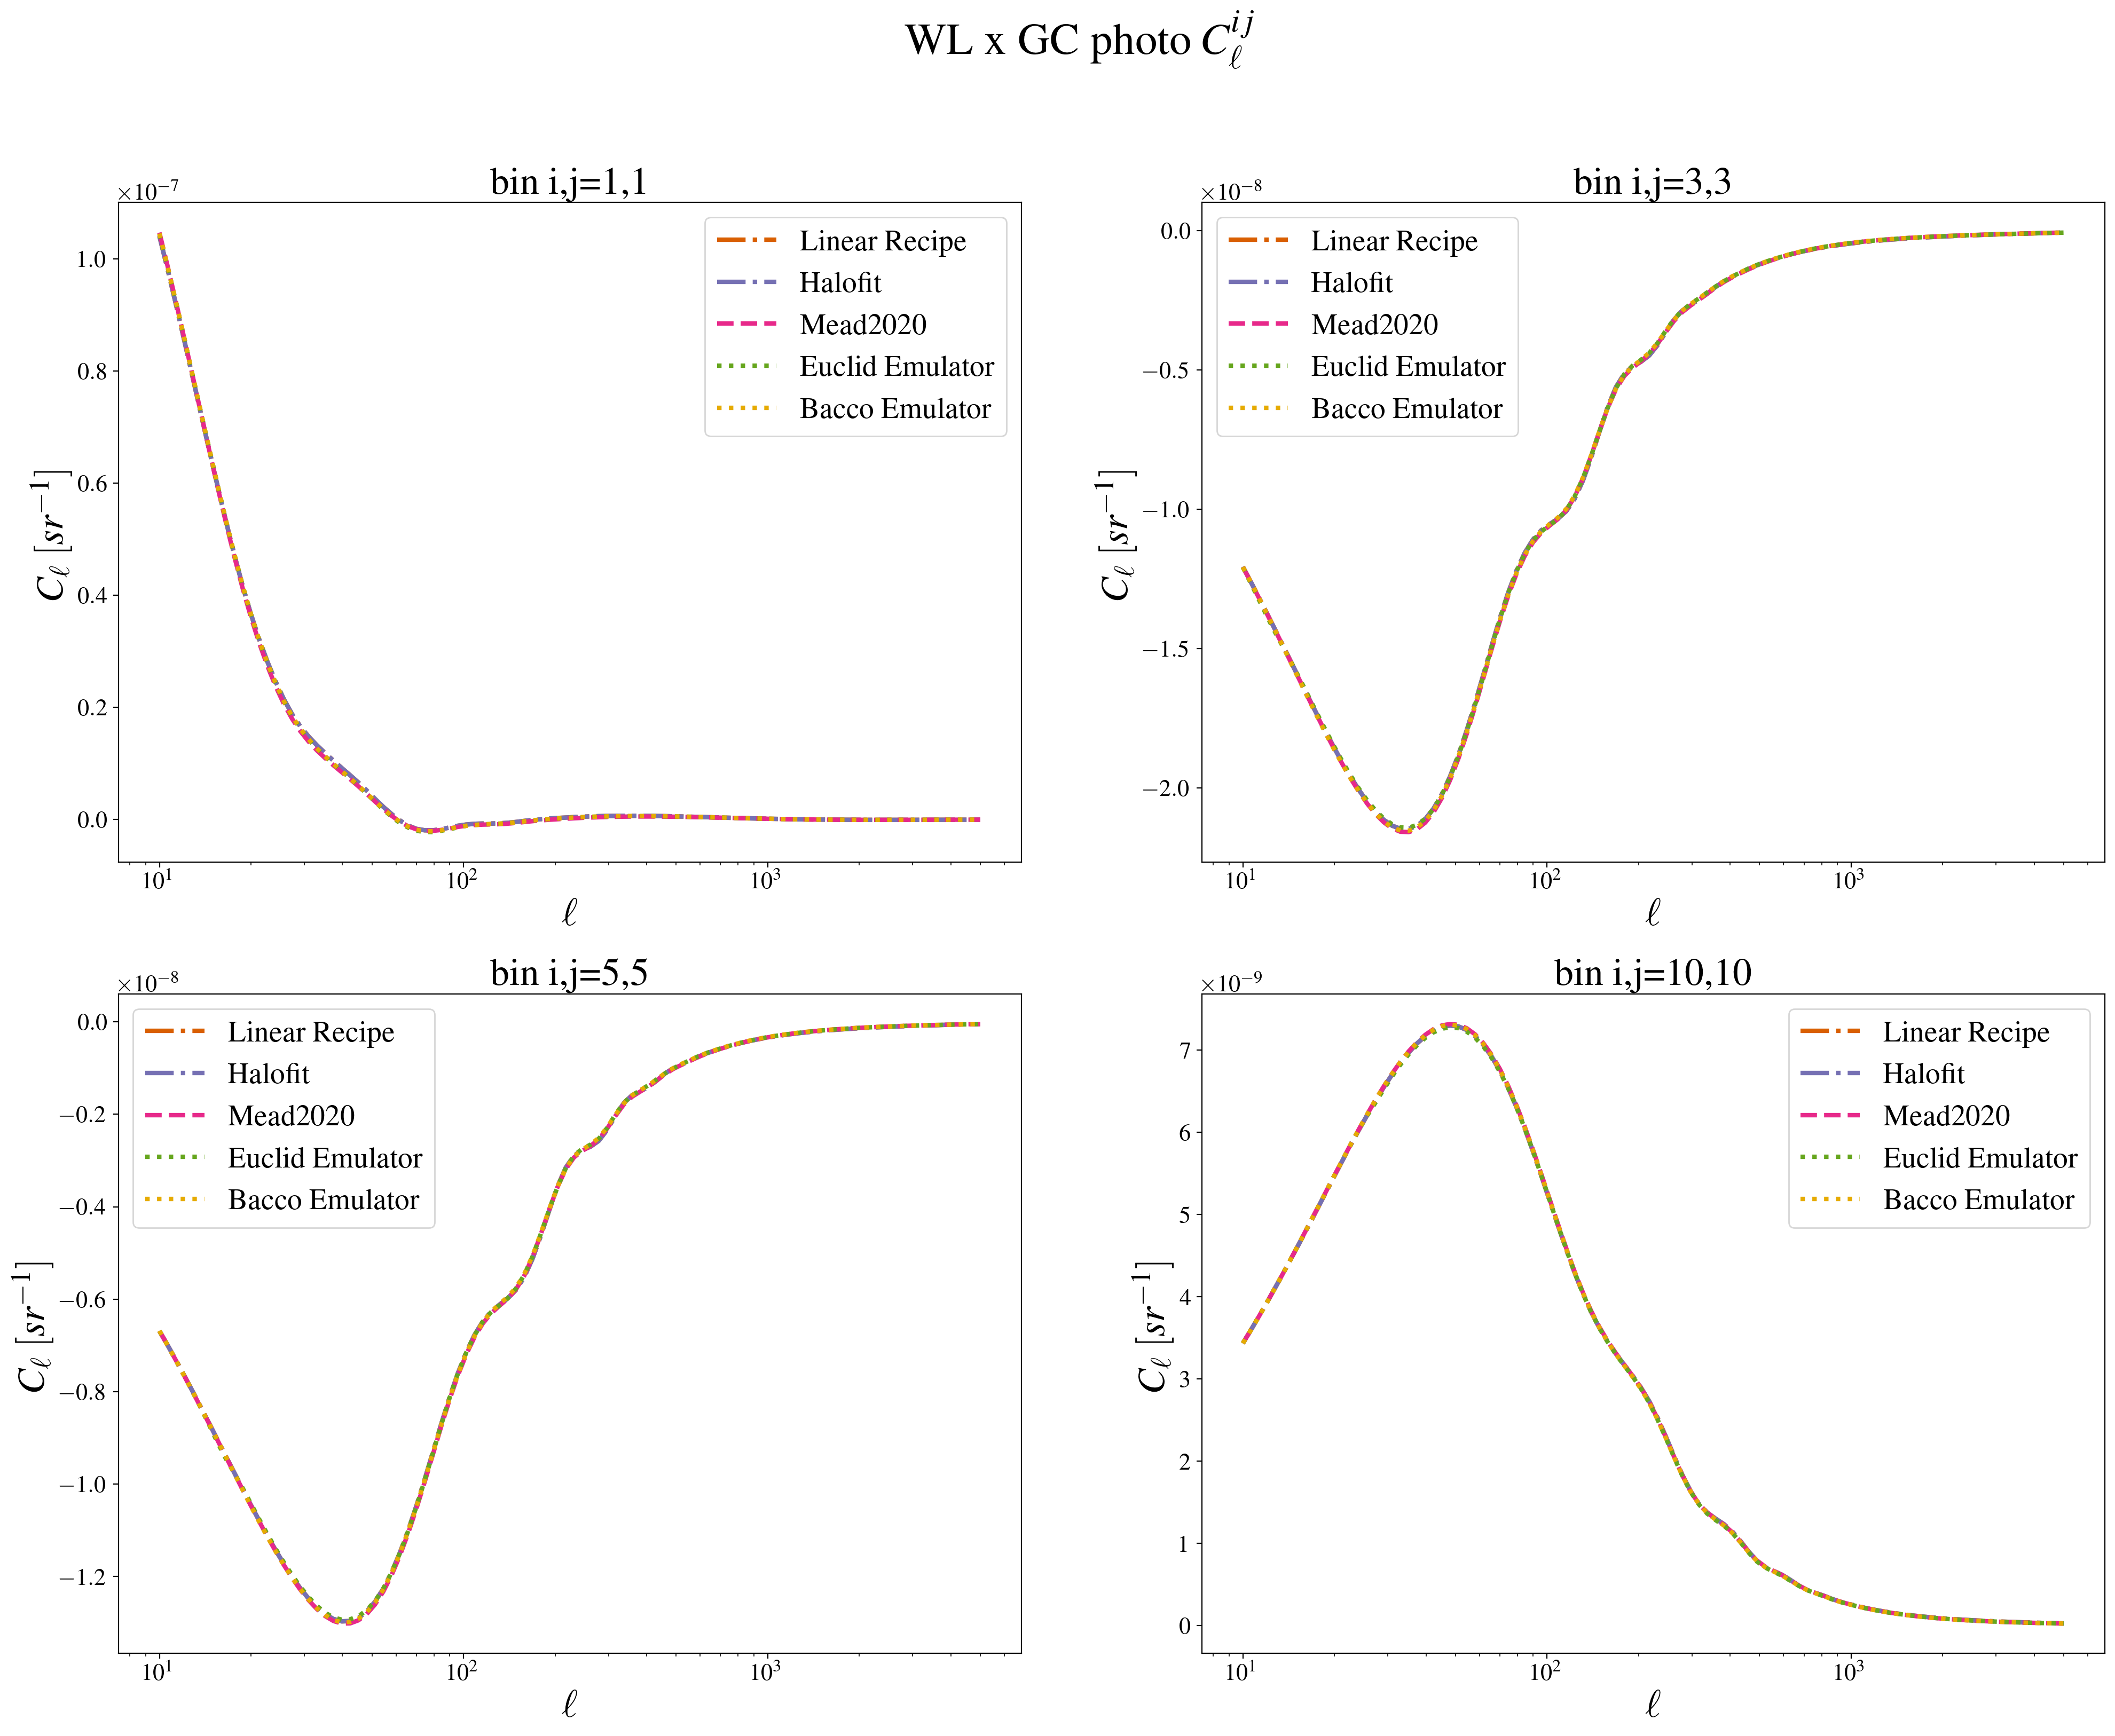

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(24,18), dpi=200)
fig.suptitle(r'WL x GC photo $C^{ij}_{\ell}$')

iz_dict={1:[0,0], 3:[0,1], 5:[1,0], 10:[1,1]}

for iz in [1,3,5,10]:
    
    ax1 = axs[iz_dict[iz][0],iz_dict[iz][1]]
    
    pl_label_0 = 'Linear Recipe'
    ax1.semilogx(ells, [ClGCxWL_1(cur_ell, iz, iz) for cur_ell in ells], color=colors[1], ls='-.', label=pl_label_0, lw=3)

    pl_label_1 = 'Halofit'
    ax1.semilogx(ells, [ClGCxWL_1(cur_ell, iz, iz) for cur_ell in ells], color=colors[2], ls='-.', label=pl_label_1, lw=3)

    pl_label_2 = 'Mead2020'
    ax1.semilogx(ells, [ClGCxWL_2(cur_ell, iz, iz) for cur_ell in ells], color=colors[3], ls='--', label=pl_label_2, lw=3)
    
    pl_label_3 = 'Euclid Emulator'
    ax1.semilogx(ells, [ClGCxWL_3(cur_ell, iz, iz) for cur_ell in ells], color=colors[4], ls=':', label=pl_label_3, lw=3)

    pl_label_4 = 'Bacco Emulator'
    ax1.semilogx(ells, [ClGCxWL_4(cur_ell, iz, iz) for cur_ell in ells], color=colors[5], ls=':', label=pl_label_4, lw=3)
    
    ax1.set_xlabel(r'$\ell$', fontsize=26)
    ax1.set_ylabel(r'$C_\ell$ $[sr^{-1}]$', fontsize=26)
    ax1.set_title('bin i,j={:d},{:d}'.format(iz,iz))
    ax1.legend();

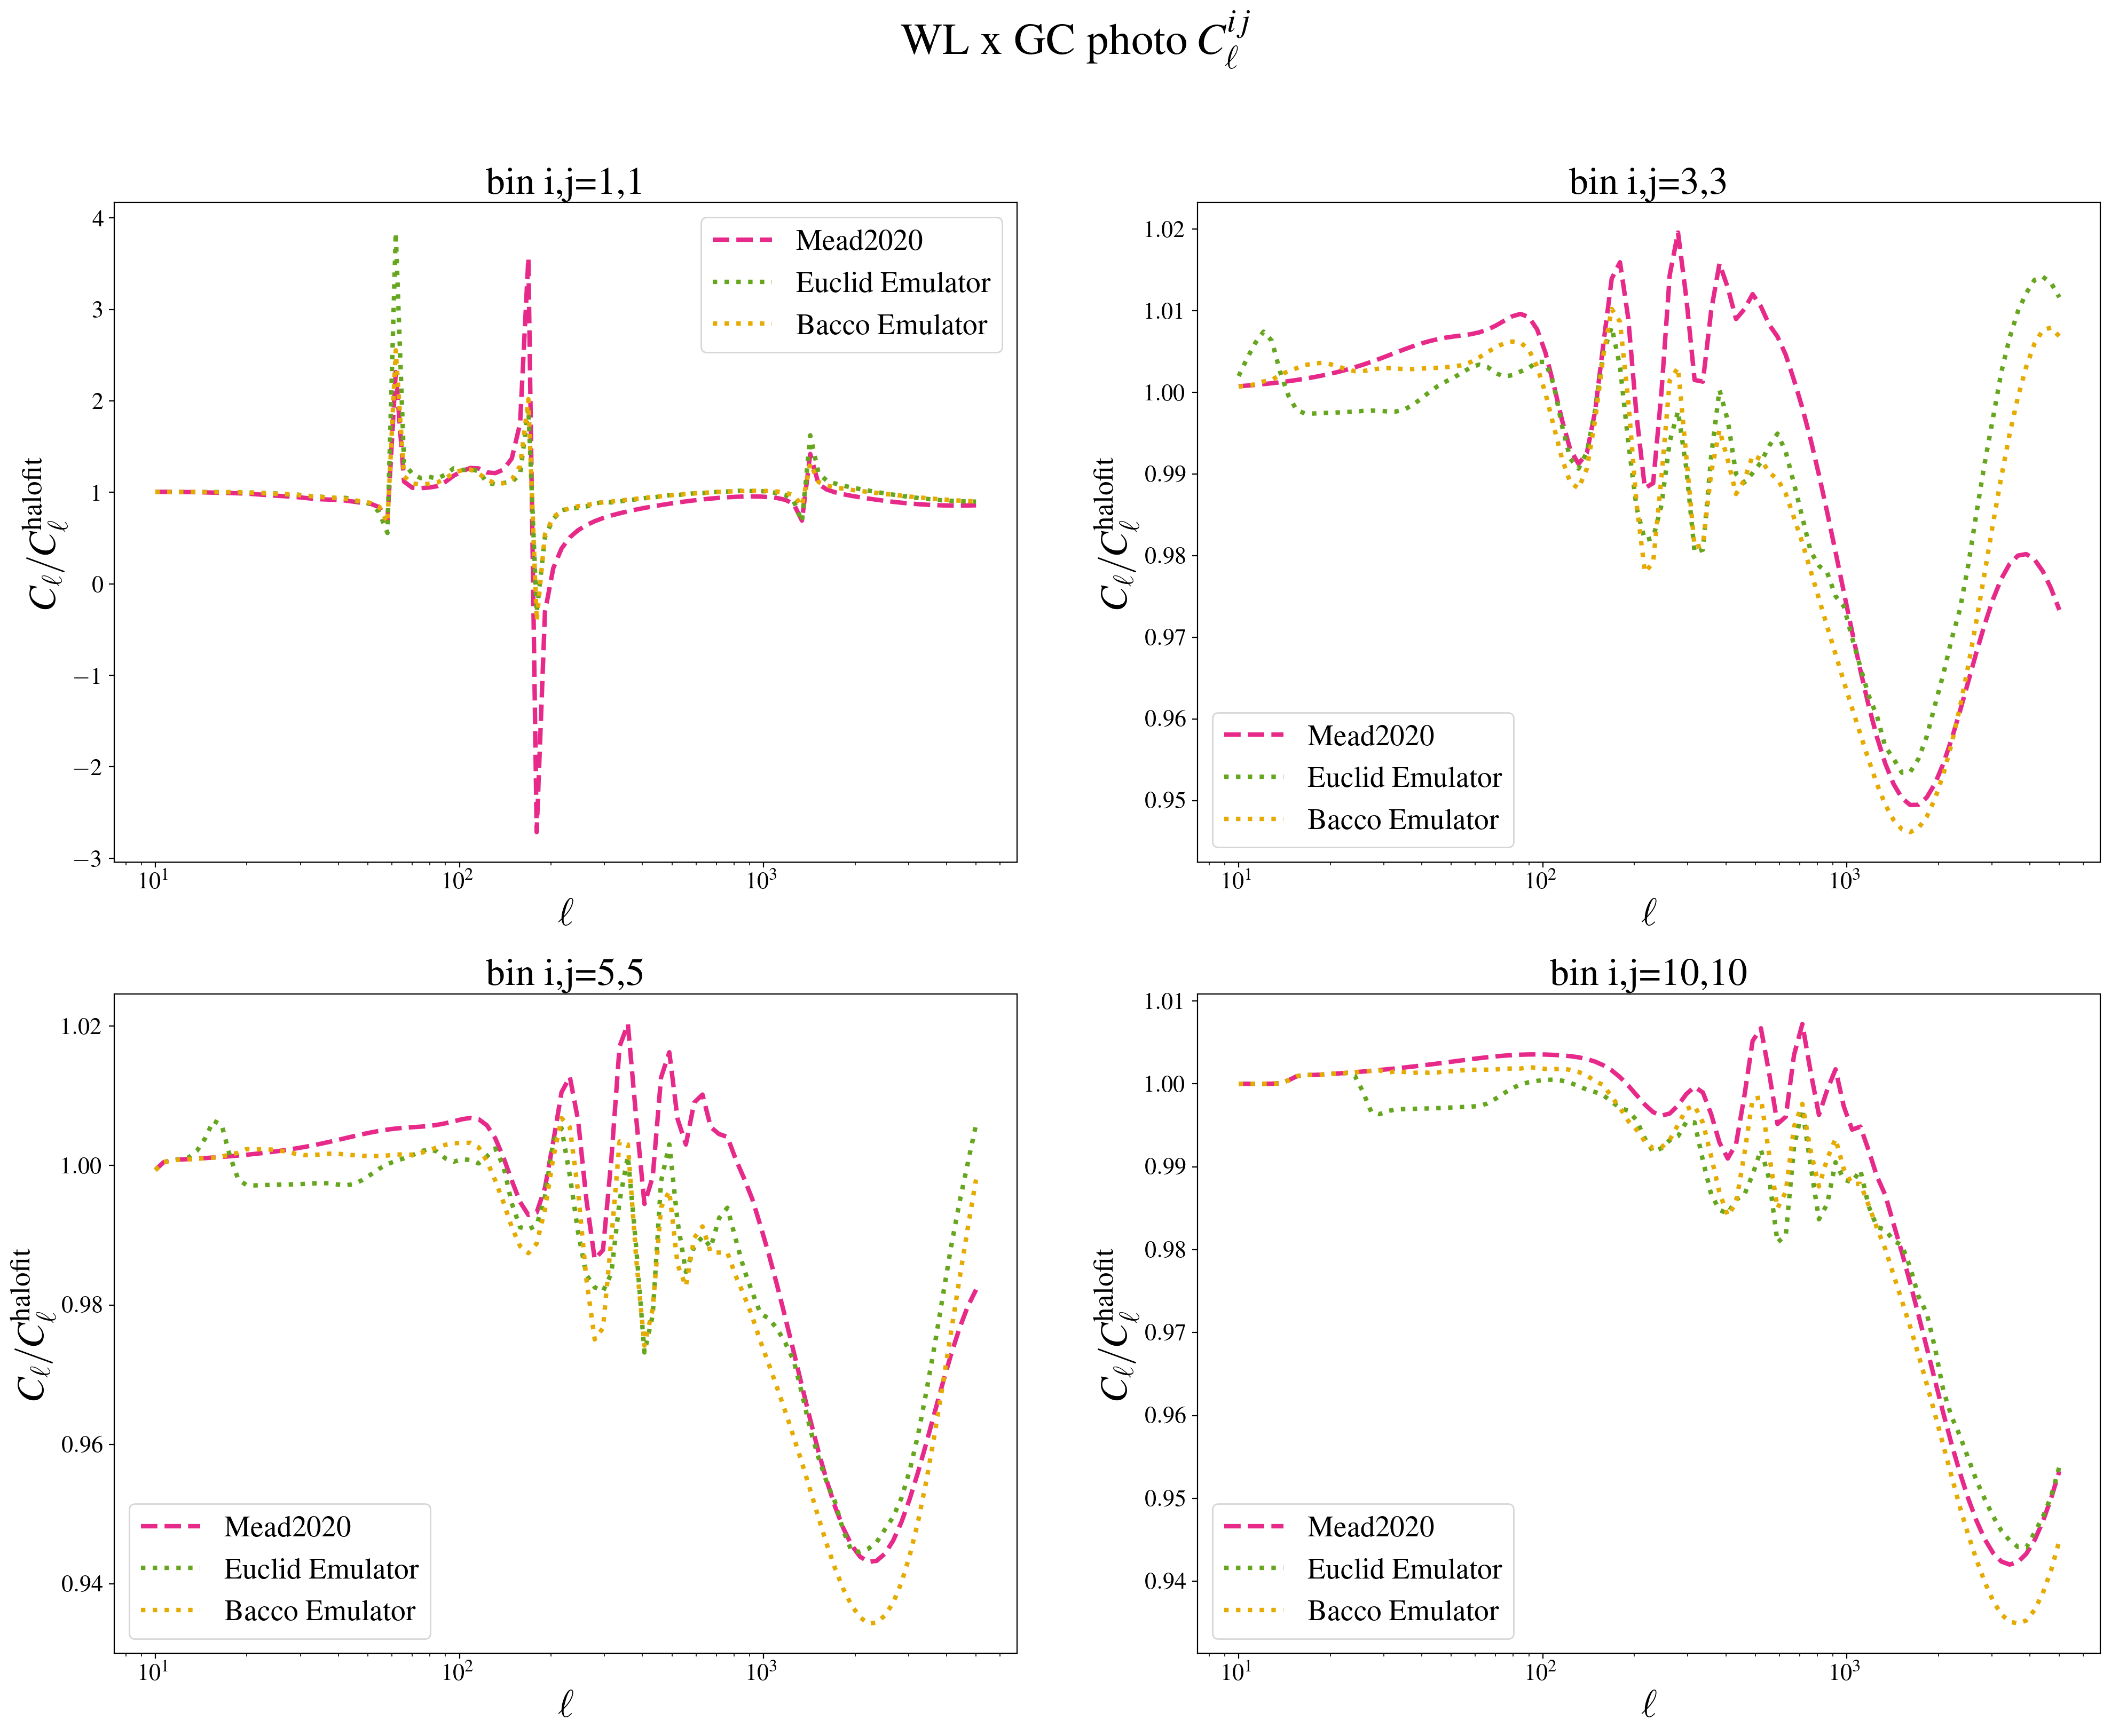

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(24,18), dpi=200)
fig.suptitle(r'WL x GC photo $C^{ij}_{\ell}$')

iz_dict={1:[0,0], 3:[0,1], 5:[1,0], 10:[1,1]}

for iz in [1,3,5,10]:
    
    ax1 = axs[iz_dict[iz][0],iz_dict[iz][1]]

    pl_label_2 = 'Mead2020'
    ax1.semilogx(ells, [ClGCxWL_2(cur_ell, iz, iz)/ClGCxWL_1(cur_ell, iz, iz) for cur_ell in ells], color=colors[3], ls='--', label=pl_label_2, lw=3)
    
    pl_label_3 = 'Euclid Emulator'
    ax1.semilogx(ells, [ClGCxWL_3(cur_ell, iz, iz)/ClGCxWL_1(cur_ell, iz, iz) for cur_ell in ells], color=colors[4], ls=':', label=pl_label_3, lw=3)

    pl_label_4 = 'Bacco Emulator'
    ax1.semilogx(ells, [ClGCxWL_4(cur_ell, iz, iz)/ClGCxWL_1(cur_ell, iz, iz) for cur_ell in ells], color=colors[5], ls=':', label=pl_label_4, lw=3)
    
    ax1.set_xlabel(r'$\ell$', fontsize=26)
    ax1.set_ylabel(r'$C_\ell/C_\ell^{\rm halofit}$', fontsize=26)
    ax1.set_title('bin i,j={:d},{:d}'.format(iz,iz))
    ax1.legend();